In [1]:
pip uninstall -y yfinance

Found existing installation: yfinance 0.2.54
Uninstalling yfinance-0.2.54:
  Successfully uninstalled yfinance-0.2.54
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yfinance --upgrade --no-cache-dir

   ---------------------------------------- 0.0/108.7 kB ? eta -:--:--
   --- ------------------------------------ 10.2/108.7 kB ? eta -:--:--
   ----------- --------------------------- 30.7/108.7 kB 330.3 kB/s eta 0:00:01
   ---------------------------------------- 108.7/108.7 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Améliorations du download:
#.  1. Télécharger et convertir la donnée https://stooq.com/db/h/
#.  2. Essayer yahooquery
#.  3. Essayer https://tiingo-python.readthedocs.io/en/latest/

In [4]:
#pip install yfinance --upgrade

In [5]:
import yfinance as yf
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import random
import time
import requests
from typing import Dict, List
import logging
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Paramètres de téléchargement
INTERVALS = ['1d']
# Paramètres système
DATA_DIR = 'datasets'  # Répertoire des données
DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'
TECH_DATA_DIR = 'datasets_technicals' #Répertoire pour sauvegarder les fichiers avec Indicateurs techniques
EDITED_DATA_DIR = 'datasets_edit'  # Répertoire pour sauvegarder les fichiers modifiés
# Paramètres de backtest
DATA_INTERVAL = '1d'  # Intervalle des données (exemple : '1m', '1h', '1d', etc.)
WINDOWS = [1800]
NUM_RANDOM_STARTS = 15
TRANSACTION_COST = 0.005

PARIS_TICKERS = [
#CAC40
    "MC.PA","OR.PA","SU.PA","AIR.PA","TTE.PA","SAN.PA","CDI.PA","EL.PA","SAF.PA","AI.PA","BNP.PA","CS.PA","AXA SA","DG.PA","DSY.PA","SGO.PA","BN.PA","ACA.PA","ENGI.PA","KER.PA","HO.PA","CAP.PA","RI.PA","LR.PA","ORA.PA","PUB.PA","GLE.PA",
    "ML.PA","DIM.PA","VIE.PA","AM.PA","BOL.PA","RNO.PA","BVI.PA","AMUN.PA","BIM.PA","AC.PA","EN.PA","ENX.PA","ADP.PA","URW.PA","SW.PA","IPN.PA","RNL.PA","ERF.PA","ALO.PA","CA.PA","FGR.PA","LI.PA","GET.PA","EDEN.PA","RXL.PA","IAM.PA","CBDG.PA","GFC.PA",
    "FDJ.PA","ODET.PA","COTY.PA","AKE.PA","AYV.PA","RF.PA","COV.PA","Covivio","GTT.PA","SPIE.PA","SPIE SA","TEP.PA","SK.PA","SEB SA","TE.PA","ELIS.PA","Elis SA","SCR.PA","VK.PA","NEX.PA","MF.PA","MLHK.PA","TKO.PA","FLY.PA","SOP.PA",
    "DEC.PA","PLX.PA","ITP.PA","VRLA.PA","SOI.PA","RCO.PA","COVH.PA","MMB.PA","ATE.PA","VU.PA","FR.PA","IDL.PA","BB.PA","RUI.PA","VIRP.PA","TRI.PA","BAIN.PA","VIV.PA","COFA.PA","CARM.PA","LOUP.PA","NK.PA","WLN.PA","ALTA.PA","UNBL.PA","IPS.PA",
    "CAF.PA","AF.PA","PLNW.PA","CBE.PA","VCT.PA","PEUG.PA","RBT.PA","EXN.PA","STF.PA","STEF SA","ICAD.PA","SESG.PA","OPM.PA","ERA.PA","ARG.PA","TFI.PA","TF1 SA","UBI.PA","OVH.PA","MMT.PA","ES.PA","BLV.PA","MAU.PA","GDS.PA","FII.PA","WAVE.PA",
    "CRLA.PA","NRO.PA","LSS.PA","MERY.PA","ETL.PA","ELEC.PA","FREY.PA","DBG.PA","CNDF.PA","LTA.PA","CDA.PA","FNAC.PA","MTU.PA","VETO.PA","TKTT.PA","VIL.PA","BEN.PA","EC.PA","VAC.PA","SAVE.PA","BASS.PA","NXI.PA","XFAB.PA","SDG.PA",
    "THEP.PA","CRAV.PA","CRSU.PA","CRAP.PA","CEN.PA","SCHP.PA","TFF.PA","KOF.PA","QDT.PA","LPE.PA","SBT.PA","EQS.PA","BUR.PA","AUB.PA","GLO.PA",
]

US_ETF = ["SOXL","SPXS","FXI","TSLL","TSLZ","SQQQ","TQQQ","SOXS","ETHU","NVDQ","SPY","KWEB","IBIT","MSTU","XLF","EEM","TLT","HYG","UVXY","EWZ","TZA","QQQ","IWM","SLV","FAZ","LQD","NVDL","LABD","AMDL","SDS","MSTZ","GDX","NVDX","SCHD","VEA","EFA","TNA","SPXU",
          "YINN","SCHF","XBI","KRE","BITX","XLE","XLV","BITO","USHY","IEMG","SCHX","XLI","UVIX","ARKK","ASHR","IEFA","EMXC","GLD","RWM","VOO","VWO","MCHI","IJH","ETHA","NVDD","XLP","MSTX","JAAA","SCHG","EWJ","XLU","SMH","IAU","TSLS","SGOL","QID","QYLD","XLB",
          "XRT","NVD","SGOV","RSP","TMF","KORU","TSLQ","BND","BIL","AGG","BKLN","SCHH","SPLG","UNG","EMLC","INDA","FEZ","CONY","SCHB","SPTI","YANG","VCIT","FNGD","GOVT","IGV","MSOS","SPDN","SRTY","GDXJ","SBIT","IQLT","VXX","SHV","PSQ","EMB","VXUS","DRIP","JEPQ",
          "IYR","VTEB","SPIB","IEF","MSTY","JPST","UPRO","FBTC","XLK","SPDW","EWH","JEPI","ILF","PGX","CONL","IJR","IYZ","SPHY","CGGR","GGLL","EWY","KOLD","SCHP","VTI","CGDV","SHY","ITB","SILJ","IVV","SPTL","BITU","SOXX","SRLN","SPXL","SDOW","XHB","TIP","EZA",
          "ETHE","XLC","FBND","VGIT","USFR","ULTY","VCRB","HEFA","GBTC","ARKG","TSLY","VGSH","XLY","SJNK","ACWI","ICLN","VTV","AMZU","MAGS","AGQ","GLDM","XOP","JCPB","VNQ","SCHA","PFF","PAVE","PDBC","EFV","QQQM","BNDX","DOG","BOIL","EWT","IUSB","EZU","BITB",
          "SPYV","JNK","SSO","BSCT","BABX","DIA","QLD","IBB","XME","RSHO","EWW","SPSM","SCHO","EWC","VEU","CALF","SCHM","SPYG","USO","BITI","TSLT","VGK","MUB","SPMD","COWZ","ETH","TMV","COPX","UDOW","AMLP","URA","NVDY","KBWB","PULS","EWA","BSV","IDEV","EWG",
          "CLOZ","VMBS","SPTS","IXUS","SVIX","VIXY","DFAC","SDVY","TFLO","SCHZ","MLPX","SPEM","SPSB","LABU","DYNF","IGSB","CGUS","ETHT","BLV","BBJP","UCO","YMAX","IAUM","VCSH","AAAU","VGLT","VTWO","SPMO","TSLR","DGRO","SPAB","KBE","AUSF","PYLD","VCLT","NVDU",
          "JETS","IWD","CWEB","FNDF","SCHR","DXD","FLOT","IGIB","BIV","JBBB","MOAT","DFIC","MBB","URNM","TBIL","QEFA","SCHE","PVAL","FGD","IEUR","XLG","NUGT","IVW","BUFR","DFSV","OUNZ","SCHI","VFLO","CQQQ","DFAI","FETH","SPLV","NVDS","GRNY","MSFU","AAPU","IEI",
          "EEMA","CIBR","CGCP","ITOT","SHYG","BSCR","IWF","TECL","RDVY","QGRW","FPE","PXH","BAR","TFI","IWP","BINC","MTUM","UUP","ACWX","PZA","GDXD","MINT","AAPD","YMAG","SPLB","IWR","USMV","TECS","VUG","ACES","QUAL","IGLB","SVXY","SCHV","BTC","IYT","AMDY","FAS",
          "AVGX","SPYD","MRNY","ARKB","VIG","ZSL","URTY","NAIL","DFLV","TCAF","ITA","KIE","URNJ","HYD","TSDD","SPYI","VUSB","VTIP","FDVV","HTRB","SCO","FTSM","AMZZ","FLTR","BIZD","PTIR","DIVO","COWG","VSS","FBL","DFEM","EPI","IOO","AVUV","VONG","VYM","FNDE","SPHQ",
          "FLRN","HYEM","MDY","SIVR","USIG","DUST","DIVI","BUG","IWB","GSLC","UCON","CHAU","AVDV","BOTZ","JDST","FNDA","IBDQ","GUNR","PAAA","AIQ","VWOB","SIL","JNUG","DBA","SCZ","DUHP","SVOL","AVEM","CGMS","DFSD","HYLB","TWM","FENY","DFCF","GDXU","XSMO","AMZY","REM"
          ,"DRN","SLYV","IYW","BSCP","BSCQ","AIYY","CGBL","DBEF","FELC","GLL","EWU","FNGU","WEAT","DFAE","USD","CGGO","EDZ","GBIL","IUSV","EFG","BTCZ","IBDV","SPTM","SPYU","DPST","OIH","EDV","AMZD","DJAN","FALN","EUFN","PFFD","METU","AIRR","ETHD","TLTW","DFAU",
          "CETH","VFH","FBCG","IDV","BSCS","GSY","ICSH","ESGE","JGRO","DBC","CTA","FIAT","SDIV","AVL","FHLC","CGXU","IBDU","LVHI","IBDS","SCHK","BUFD","DFAX","TLH","JMST","FJP","IBDR","DFIV","DGRW","FIXD","RYLD","QDTE","EVTR","FLCB","BBIN","JMEE","WGMI","SPGP",
          "HYMB","JPIE","IWN",]

EU_ETF = ["BX4.PA","BXX.PA","WPEA.PA","DSD.PA","AUEM.PA","MSE.PA","ESE.PA","SHC.PA","AEEM.PA","MFEC.PA","DFND-EUR.PA","BNKE.PA","LVC.PA","500U.PA","LCWD.PA","PSP5.PA","GRE.PA","ESEH.PA","CL2.PA","ISRA.PA","BNK.PA","ETZ.PA","PASI.PA","SEME.PA","ETZD.PA",
          "CNY.PA","PAASI.PA","PSPH.PA","ESD.PA","ABDJI.PA","ABNSP.PA","AABCH.PA","AATCX.PA","AAHLT.PA","ABSMI.PA","CACC.PA","PUST.PA","AAFIN.PA","AABFB.PA","GEMU.PA","AARTL.PA","OBLI.PA","8G19V.PA","NB22V.PA","NB28V.PA","SPEEU.PA","ERTH.PA","AABEN.PA",
          "ABDJE.PA","ABHSN.PA","AAUTL.PA","AAINS.PA","HSTE.PA","SP5.PA","AASTX.PA","ABNSQ.PA","BRES.PA","PE500.PA","HEMA.PA","AABKX.PA","PAEEM.PA","EEE.PA","AATLC.PA","E40.PA","MUSRI.PA","ESDD.PA","XQ48V.PA","CAC.PA","UST.PA","EEMK.PA","CEC.PA",
          "EGRI.PA","ETHC-EUR.PA","0G28.IL","0Y4H.IL","0MPR.IL","WDTE.L","0MPY.IL","TS3S.L","0A09.L","XT2D.L","0DZF.IL","CNYA.L","SUOE.L","FRXD.L","WHCE.L","XSD2.L","0HOV.IL","ISF.L","JCAU.L","N100.L","0Y8R.IL",
          "DTLA.L","0MRJ.IL","IBTA.L","SUSW.L","SPEH.L","HIGG.L","0XC5.IL","HAGG.L","UC76.L","FBTC.L","AGBP.L","MIDD.L","FUSR.L","0DZB.L","DTLE.L","0MMG.IL","IGLT.L","0Y2B.L","SDIA.L","IEBB.IL","0GBX.IL","JCPN.L",
          "IHYA.L","EWSX.L","0L4R.L","HYLA.L","IDTL.L","EWSP.L","IUIT.L","WNDI.L","0DYZ.IL","0HEP.L","PAWD.L","HCGU.L","0MP3.IL","SNGB.L","0WA3.IL","MTHG.L","FLOA.L","EMAU.L","LQDA.L","HGAS.L","IEAC.L",
          "V3SU.L","AREG.L","0H9U.L","NDIA.L","FWRG.L","IGTM.L","TSLQ.L","GDMS.L","0WA5.IL","UIFS.L","XGSI.L","0KZC.L","BS0A.L","XDNS.L","I50D.L","QQQ5.L"]

CURRENCY_AND_FUTURES = ["ZN=F","ZF=F","ES=F","ZT=F","NQ=F","ZB=F","CL=F","GC=F","ZC=F","RTY=F","NG=F","MGC=F","YM=F","ZS=F","HG=F","SI=F","SB=F","HO=F","RB=F","ZL=F","KE=F","ZM=F","BZ=F","CT=F","KC=F","PL=F","LE=F","SIL=F",
                        "HE=F","CC=F","GF=F","PA=F","EURUSD=X","JPY=X","GBPUSD=X","AUDUSD=X","NZDUSD=X","EURJPY=X","GBPJPY=X","EURGBP=X","EURCAD=X","EURSEK=X","EURCHF=X","EURHUF=X","CNY=X","HKD=X",
                        "SGD=X","INR=X","MXN=X","PHP=X","IDR=X","THB=X","MYR=X","ZAR=X","RUB=X"]

US_TICKERS = [
    #US main tickers
'NVDA','AAPL','MSFT','AMZN','GOOGL','GOOG','META','TSLA','AVGO','BRK-B','ORCL','TCEHY','TCTZF','NFLX','COST','NONOF','LVMHF','LVMUY','JPM-PD','JPM-PC','BML-PG','SAPGF','BML-PH','BML-PL','BAC-PE','IDCBY','BAC-PK','SSNLF','ABBV','IDCBF','HESAY','ASMLF','ASML','GDVTZ',
    'ACGBF','TMUS','BML-PJ','BAC-PB','RHHBF','CSCO','RHHVF','RHHBY','TOYOF','ACGBY','BABAF','AZNCF','BABA','NSRGY','NSRGF','ISRG','CICHY','RYDAF','BACHY','LRLCY','WFC-PY','NVSEF','BACHF','SHEL','CICHF','LRLCF','PCCYF','ADBE','QCOM','HBCYF','HSBC','CMWAY','PLTR','SIEGY',
    'SMAWF','INTU','ANET','CBAUF','IDEXF','SBGSF','SPGI','IDEXY','SBGSY','MBFJF','DTEGF','AMAT','DTEGY','FMXUF','SCHW','CIHKY','MUFG','AMGN','UBER','CMCSA','UNLYF','SHOP','EADSF','EADSY','BHPLF','SNYNF','TTFNF','SNEJF','CHDRY','CILJF','SONY','CHDRF',
    'WFC-PC','ALIZF','ALIZY','HTHIF','ESLOY','RTNTF','HTHIY','MPNGF','Meituan','ESLOF','CIHHF','XIACY','MPNGY','Meituan','PNGAY','XIACF','CIIHF','GILD','PIAIF','VRTX','BYDDF','BYDDY','SBUX','SAFRF','SAFRY','CFRUY','CUAEF','CFRHF','ABBNY','ABLZF','MRVL','KYCCF','RCRUY',
    'UNCFF','UNCRY','CSUAY','SPOT','FRCOF','RCRRF','LRCX','KLAC','SMFNF','SNPMF','SFTBF','FRCOY','AIQUY','AIQUF','SFTBY','SMFG','RTPPF','BUDFF','USB-PH','IBKR','CRWD','DBSDY','RLXXF','EQIX','RELX','INTC','INFY','IVSXF','PYPL','EBBNF','DBSDF','PROSF','PROSY','GS-PA','IBDRY',
    'IBDSF','CDNS','NPPXF','IVSBF','ZFSVF','MS-PA','ZURVY','WELL','BNPQF','BNPQY','SNPS','ATLCY','TOELF','BPAQF','AXAHF','AXAHY','CSLLY','MSTR','CMXHF','ATLKY','MS-PK','TOELY','GS-PD','MS-PI','PBR-A','NTTYY','MS-PF','IITSF','BTAFF','BCDRF','DELL','CTAS','ABNB','MS-PE','AAIGF',
    'LNSTY','LDNXF','ISNPY','RACE','MDLZ','HNHPF','AAGIY','SCCO','DASH','CGXYY','PBCRF','USB-PP','COIN','NTDOF','SBKFF','FTNT','REGN','NTDOY','MURGY','MURGF','PBCRY','ESOCF','WEBNF','ENLAY','NABZY','BKFCF','PSTVY','GLAXF','BCMXY','TEAM','CHGCY','TKOMF','CHGCF','PSBKF','WDAY',
    'ITOCF','RLLCF','MKGAF','NTES','MKKGY','SHECY','BBVXF','ITOCY','STOHF','RBSPF','TKOMY','DGEAF','EQNR','PPWLM','ADSK','BBVA','RYCEF'
]
# Liste de tickers (sans leverage)
TICKERS =['MC.PA', 'OR.PA', 'SU.PA', 'AIR.PA', 'TTE.PA', 'SAN.PA', 'CDI.PA', 'EL.PA', 'SAF.PA', 'AI.PA', 'BNP.PA', 'CS.PA', 'AXA SA', 'DG.PA', 'DSY.PA', 'SGO.PA', 'BN.PA', 'ACA.PA', 'ENGI.PA', 'KER.PA', 'HO.PA', 'CAP.PA', 'RI.PA', 'LR.PA', 'ORA.PA', 'PUB.PA',
          'GLE.PA', 'ML.PA', 'DIM.PA', 'VIE.PA', 'AM.PA', 'BOL.PA', 'RNO.PA', 'BVI.PA', 'AMUN.PA', 'BIM.PA', 'AC.PA', 'EN.PA', 'ENX.PA', 'ADP.PA', 'URW.PA', 'SW.PA', 'IPN.PA', 'RNL.PA', 'ERF.PA', 'ALO.PA', 'CA.PA', 'FGR.PA', 'LI.PA', 'GET.PA', 'EDEN.PA',
          'RXL.PA', 'IAM.PA', 'CBDG.PA', 'GFC.PA', 'FDJ.PA', 'ODET.PA', 'COTY.PA', 'AKE.PA', 'AYV.PA', 'RF.PA', 'COV.PA', 'GTT.PA', 'SPIE.PA', 'SPIE SA', 'TEP.PA', 'SK.PA', 'SEB SA', 'TE.PA', 'ELIS.PA', 'Elis SA', 'SCR.PA', 'VK.PA', 'NEX.PA', 'MF.PA', 
          'MLHK.PA', 'TKO.PA', 'FLY.PA', 'SOP.PA', 'DEC.PA', 'PLX.PA', 'ITP.PA', 'VRLA.PA', 'SOI.PA', 'RCO.PA', 'COVH.PA', 'MMB.PA', 'ATE.PA', 'VU.PA', 'FR.PA', 'IDL.PA', 'BB.PA', 'RUI.PA', 'VIRP.PA', 'TRI.PA', 'BAIN.PA', 'VIV.PA', 'COFA.PA', 'CARM.PA',
          'LOUP.PA', 'NK.PA', 'WLN.PA', 'ALTA.PA', 'UNBL.PA', 'IPS.PA', 'CAF.PA', 'AF.PA', 'PLNW.PA', 'CBE.PA', 'VCT.PA', 'PEUG.PA', 'RBT.PA', 'EXN.PA', 'STF.PA', 'STEF SA', 'ICAD.PA', 'SESG.PA', 'OPM.PA', 'ERA.PA', 'ARG.PA', 'TFI.PA', 'UBI.PA', 'OVH.PA',
          'MMT.PA', 'ES.PA', 'BLV.PA', 'MAU.PA', 'GDS.PA', 'FII.PA', 'WAVE.PA', 'CRLA.PA', 'NRO.PA', 'LSS.PA', 'MERY.PA', 'ETL.PA', 'ELEC.PA', 'FREY.PA', 'DBG.PA', 'CNDF.PA', 'LTA.PA', 'CDA.PA', 'FNAC.PA', 'MTU.PA', 'VETO.PA', 'TKTT.PA', 'VIL.PA', 'BEN.PA',
          'EC.PA', 'VAC.PA', 'SAVE.PA', 'BASS.PA', 'NXI.PA', 'XFAB.PA', 'SDG.PA', 'THEP.PA', 'CRAV.PA', 'CRSU.PA', 'CRAP.PA', 'CEN.PA', 'SCHP.PA', 'TFF.PA', 'KOF.PA', 'QDT.PA', 'LPE.PA', 'SBT.PA', 'EQS.PA', 'BUR.PA', 'AUB.PA', 'GLO.PA', 'NVDA', 'AAPL', 'MSFT',
          'AMZN', 'GOOGL', 'GOOG', 'META', 'TSLA', 'AVGO', 'BRK-B', 'ORCL', 'TCEHY', 'TCTZF', 'NFLX', 'COST', 'NONOF', 'LVMHF', 'LVMUY', 'JPM-PD', 'JPM-PC', 'BML-PG', 'SAPGF', 'BML-PH', 'BML-PL', 'BAC-PE', 'IDCBY', 'BAC-PK', 'SSNLF', 'ABBV', 'IDCBF', 'HESAY',
          'ASMLF', 'ASML', 'GDVTZ', 'ACGBF', 'TMUS', 'BML-PJ', 'BAC-PB', 'RHHBF', 'CSCO', 'RHHVF', 'RHHBY', 'TOYOF', 'ACGBY', 'BABAF', 'AZNCF', 'BABA', 'NSRGY', 'NSRGF', 'ISRG', 'CICHY', 'RYDAF', 'BACHY', 'LRLCY', 'WFC-PY', 'NVSEF', 'BACHF', 'SHEL', 'CICHF',
          'LRLCF', 'PCCYF', 'ADBE', 'QCOM', 'HBCYF', 'HSBC', 'CMWAY', 'PLTR', 'SIEGY', 'SMAWF', 'INTU', 'ANET', 'CBAUF', 'IDEXF', 'SBGSF', 'SPGI', 'IDEXY', 'SBGSY', 'MBFJF', 'DTEGF', 'AMAT', 'DTEGY', 'FMXUF', 'SCHW', 'CIHKY', 'MUFG', 'AMGN', 'UBER', 'CMCSA',
          'UNLYF', 'SHOP', 'EADSF', 'EADSY', 'BHPLF', 'SNYNF', 'TTFNF', 'SNEJF', 'CHDRY', 'CILJF', 'SONY', 'CHDRF', 'WFC-PC', 'ALIZF', 'ALIZY', 'HTHIF', 'ESLOY', 'RTNTF', 'HTHIY', 'MPNGF', 'ESLOF', 'CIHHF', 'XIACY', 'MPNGY', 'PNGAY', 'XIACF', 'CIIHF', 'GILD',
          'PIAIF', 'VRTX', 'BYDDF', 'BYDDY', 'SBUX', 'SAFRF', 'SAFRY', 'CFRUY', 'CUAEF', 'CFRHF', 'ABBNY', 'ABLZF', 'MRVL', 'KYCCF', 'RCRUY', 'UNCFF', 'UNCRY', 'CSUAY', 'SPOT', 'FRCOF', 'RCRRF', 'LRCX', 'KLAC', 'SMFNF', 'SNPMF', 'SFTBF', 'FRCOY', 'AIQUY',
          'AIQUF', 'SFTBY', 'SMFG', 'RTPPF', 'BUDFF', 'USB-PH', 'IBKR', 'CRWD', 'DBSDY', 'RLXXF', 'EQIX', 'RELX', 'INTC', 'INFY', 'IVSXF', 'PYPL', 'EBBNF', 'DBSDF', 'PROSF', 'PROSY', 'GS-PA', 'IBDRY', 'IBDSF', 'CDNS', 'NPPXF', 'IVSBF', 'ZFSVF', 'MS-PA',
          'ZURVY', 'WELL', 'BNPQF', 'BNPQY', 'SNPS', 'ATLCY', 'TOELF', 'BPAQF', 'AXAHF', 'AXAHY', 'CSLLY', 'MSTR', 'CMXHF', 'ATLKY', 'MS-PK', 'TOELY', 'GS-PD', 'MS-PI', 'PBR-A', 'NTTYY', 'MS-PF', 'IITSF', 'BTAFF', 'BCDRF', 'DELL', 'CTAS', 'ABNB', 'MS-PE',
          'AAIGF', 'LNSTY', 'LDNXF', 'ISNPY', 'RACE', 'MDLZ', 'HNHPF', 'AAGIY', 'SCCO', 'DASH', 'CGXYY', 'PBCRF', 'USB-PP', 'COIN', 'NTDOF', 'SBKFF', 'FTNT', 'REGN', 'NTDOY', 'MURGY', 'MURGF', 'PBCRY', 'ESOCF', 'WEBNF', 'ENLAY', 'NABZY', 'BKFCF', 'PSTVY',
          'GLAXF', 'BCMXY', 'TEAM', 'CHGCY', 'TKOMF', 'CHGCF', 'PSBKF', 'WDAY', 'ITOCF', 'RLLCF', 'MKGAF', 'NTES', 'MKKGY', 'SHECY', 'BBVXF', 'ITOCY', 'STOHF', 'RBSPF', 'TKOMY', 'DGEAF', 'EQNR', 'PPWLM', 'ADSK', 'BBVA', 'RYCEF', 'DBK.DE', 'EI.PA', 'ENEL.MI',
          'FRE.DE', 'IBE.MC', 'INGA.AS', 'ISP.MI', 'EOAN.DE', 'G.MI', 'ALV.DE', 'BBVA.MC', 'BAYN.DE', 'ABI.BR', 'ENI.MI', 'BMW.DE', 'ASML.AS', 'DTE.DE', 'BAS.DE', 'EURUSD=X', 'MT.AS', 'RMS.PA', 'STLAP.PA', 'STMPA.PA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'MA',
          'DIS', 'HD', 'VZ', 'UNH', 'KO', 'PFE', 'XOM', 'MRK', 'NKE', 'ABT', 'PEP', 'CRM', 'TMO', 'MDT', 'LLY', 'MS', 'BA', 'STLA', 'NESN.SW', 'A', 'AAL', 'AAP', 'ACN', 'ADI', 'ADM', 'ADP', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM',
          'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMD', 'AME', 'AMP', 'AMT', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVY', 'AWK', 'AXP', 'AZO', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR',
          'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CE', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'CPB', 'CPRT', 'CSX', 'CVS',
          'CVX', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DLR', 'DLTR', 'DOV', 'DOW', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQR', 'ES', 'ESS', 'ETN', 'ETR', 'EVRG',
          'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FITB', 'FLR', 'FLS', 'FMC', 'FOX', 'FOXA', 'FTV', 'GD', 'GE', 'GIS', 'GL', 'GLW', 'GM', 'GPC', 'GPN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HBI', 'HCA', 'HCP',
          'HES', 'HIG', 'HII', 'HLT', 'HOG', 'HOLX', 'HON', 'HP', 'HPE', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HST', 'HSY', 'HUM', 'IBM', 'ICE', 'IDXX', 'IEX', 'IFF', 'ILMN', 'INCY', 'INFO', 'IP', 'IPG', 'IPGP', 'IQV', 'IR', 'IRM', 'IT', 'ITW', 'IVZ', 'J', 'JBHT',
          'JCI', 'JKHY', 'JNPR', 'JWN', 'K', 'KEY', 'KEYS', 'KHC', 'KIM', 'KMB', 'KMI', 'KMX', 'KR', 'KSS', 'L', 'LB', 'LDOS', 'LEG', 'LEN', 'LH', 'LHX', 'LIN', 'LKQ', 'LMT', 'LNC', 'LNT', 'LOW', 'LUV', 'LW', 'LYB', 'M', 'MAA', 'MAC', 'MAR', 'MAS', 'MCD',
          'MCHP', 'MCK', 'MCO', 'MET', 'MGM', 'MHK', 'MKC', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST', 'MO', 'MOS', 'MPC', 'MSCI', 'MSI', 'MTB', 'MTD', 'MU', 'NAVI', 'NCLH', 'NDAQ', 'NEE', 'NEM', 'NI', 'NOC', 'NOV', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVR', 'NWL',
          'NWS', 'NWSA', 'O', 'ODFL', 'OKE', 'OMC', 'ORLY', 'OXY', 'PAYC', 'PAYX', 'PCAR', 'PEG', 'PFG', 'PGR', 'PH', 'PHM', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PPG', 'PPL', 'PRGO', 'PRU', 'PSA', 'PSX', 'PVH', 'PWR', 'QRVO', 'RCL', 'REG', 'RF', 'RHI', 'RJF',
          'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG', 'RTX', 'SBAC', 'SEE', 'SHW', 'SJM', 'SLB', 'SLG', 'SNA', 'SO', 'SPG', 'SRE', 'STE', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYY', 'T', 'TAP', 'TDG', 'TEL', 'TER', 'TFC', 'TFX', 'TGT', 'TJX', 'TPR', 'TRMB', 
          'TROW', 'TRV', 'TSCO', 'TSN', 'TT', 'TTWO', 'TXN', 'TXT', 'TYL', 'UA', 'UAA', 'UAL', 'UDR', 'UHS', 'ULTA', 'UNM', 'UNP', 'UPS', 'URI', 'USB', 'VFC', 'VLO', 'VMC', 'VNO', 'VRSK', 'VRSN', 'VTR', 'WAB', 'WAT', 'WBA', 'WDC', 'WEC', 'WFC', 'WHR', 'WM', 
          'WMB', 'WRB', 'WU', 'WY', 'WYNN', 'XEL', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS', 'ADS.DE', 'CON.DE', 'DB1.DE', 'LHA.DE', 'LIN.DE', 'MUV2.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 'VOW3.DE', 'ZAL.DE', 'AAL.L', 'ABF.L', 'ADM.L', 'AHT.L', 
          'AV.L', 'BA.L', 'BARC.L', 'BATS.L', 'BP.L', 'BTI', 'CNA.L', 'DGE.L', 'GSK.L', 'HSBA.L', 'IMB.L', 'ITV.L', 'LGEN.L', 'LLOY.L', 'RDSA.VI', 'PUM.DE', 'NOKIA.HE', '2388.HK', '1398.HK', '600519.SS', '601988.SS', '601288.SS', '601318.SS', '000651.SZ', 
          '002475.SZ', 'BHP.AX', 'CBA.AX', 'TLS.AX', 'WBC.AX', 'CSL.AX', 'NAB.AX', 'ANZ.AX', 'RIO.AX', 'QBE.AX', 'WOW.AX', 'S32.AX', 'FMG.AX', 'MQG.AX', 'TD.TO', 'RY.TO', 'BNS.TO', 'ENB.TO', 'SU.TO', 'CNQ.TO', 'BMO.TO', 'SHOP.TO', 'SLF.TO', 'MFC.TO', 'PPL.TO',
          'TRP.TO', 'TSM', 'SAP', 'VOW.DE', 'ZN=F', 'ZF=F', 'ES=F', 'ZT=F', 'NQ=F', 'ZB=F', 'CL=F', 'GC=F', 'ZC=F', 'RTY=F', 'NG=F', 'MGC=F', 'YM=F', 'ZS=F', 'HG=F', 'SI=F', 'SB=F', 'HO=F', 'RB=F', 'ZL=F', 'KE=F', 'ZM=F', 'BZ=F', 'CT=F', 'KC=F', 'PL=F', 'LE=F', 
          'SIL=F', 'HE=F', 'CC=F', 'GF=F', 'PA=F', 'EURUSD=X', 'JPY=X', 'GBPUSD=X', 'AUDUSD=X', 'NZDUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'EURCAD=X', 'EURSEK=X', 'EURCHF=X', 'EURHUF=X', 'CNY=X', 'HKD=X', 'SGD=X', 'INR=X', 'MXN=X', 'PHP=X', 'IDR=X', 'THB=X',
          'MYR=X', 'ZAR=X', 'RUB=X', 'BX4.PA', 'BXX.PA', 'WPEA.PA', 'DSD.PA', 'AUEM.PA', 'MSE.PA', 'ESE.PA', 'SHC.PA', 'AEEM.PA', 'MFEC.PA', 'DFND-EUR.PA', 'BNKE.PA', 'LVC.PA', '500U.PA', 'LCWD.PA', 'PSP5.PA', 'GRE.PA', 'ESEH.PA', 'CL2.PA', 'ISRA.PA', 'BNK.PA', 
          'ETZ.PA', 'PASI.PA', 'SEME.PA', 'ETZD.PA', 'CNY.PA', 'PAASI.PA', 'PSPH.PA', 'ESD.PA', 'ABDJI.PA', 'ABNSP.PA', 'AABCH.PA', 'AATCX.PA', 'AAHLT.PA', 'ABSMI.PA', 'CACC.PA', 'PUST.PA', 'AAFIN.PA', 'AABFB.PA', 'GEMU.PA', 'AARTL.PA', 'OBLI.PA', '8G19V.PA', 
          'NB22V.PA', 'NB28V.PA', 'SPEEU.PA', 'ERTH.PA', 'AABEN.PA', 'ABDJE.PA', 'ABHSN.PA', 'AAUTL.PA', 'AAINS.PA', 'HSTE.PA', 'SP5.PA', 'AASTX.PA', 'ABNSQ.PA', 'BRES.PA', 'PE500.PA', 'HEMA.PA', 'AABKX.PA', 'PAEEM.PA', 'EEE.PA', 'AATLC.PA', 'E40.PA', 'MUSRI.PA',
          'ESDD.PA', 'XQ48V.PA', 'CAC.PA', 'UST.PA', 'EEMK.PA', 'CEC.PA', 'EGRI.PA', 'ETHC-EUR.PA', '0G28.IL', '0Y4H.IL', '0MPR.IL', 'WDTE.L', '0MPY.IL', 'TS3S.L', '0A09.L', 'XT2D.L', '0DZF.IL', 'CNYA.L', 'SUOE.L', 'FRXD.L', 'WHCE.L', 'XSD2.L', '0HOV.IL', 'ISF.L',
          'JCAU.L', 'N100.L', '0Y8R.IL', 'DTLA.L', '0MRJ.IL', 'IBTA.L', 'SUSW.L', 'SPEH.L', 'HIGG.L', '0XC5.IL', 'HAGG.L', 'UC76.L', 'FBTC.L', 'AGBP.L', 'MIDD.L', 'FUSR.L', '0DZB.L', 'DTLE.L', '0MMG.IL', 'IGLT.L', '0Y2B.L', 'SDIA.L', 'IEBB.IL', '0GBX.IL', 'JCPN.L',
          'IHYA.L', 'EWSX.L', '0L4R.L', 'HYLA.L', 'IDTL.L', 'EWSP.L', 'IUIT.L', 'WNDI.L', '0DYZ.IL', '0HEP.L', 'PAWD.L', 'HCGU.L', '0MP3.IL', 'SNGB.L', '0WA3.IL', 'MTHG.L', 'FLOA.L', 'EMAU.L', 'LQDA.L', 'HGAS.L', 'IEAC.L', 'V3SU.L', 'AREG.L', '0H9U.L',
          'NDIA.L', 'FWRG.L', 'IGTM.L', 'GDMS.L', '0WA5.IL', 'UIFS.L', 'XGSI.L', '0KZC.L', 'BS0A.L', 'XDNS.L', 'I50D.L',  'FXI', 'SPY', 'KWEB', 'IBIT', 'MSTU', 'XLF', 'EEM', 'TLT', 'HYG', 'EWZ',  'IWM', 'SLV', 'LQD', 'MSTZ', 'GDX',
          'SCHD', 'VEA', 'EFA', 'SCHF', 'XBI', 'KRE', 'XLE', 'XLV', 'BITO', 'USHY', 'IEMG', 'SCHX', 'XLI', 'ARKK', 'ASHR', 'IEFA', 'EMXC', 'GLD', 'RWM', 'VOO', 'VWO', 'MCHI', 'IJH', 'ETHA', 'XLP', 'MSTX', 'JAAA', 'SCHG', 'EWJ', 'XLU', 'SMH', 'IAU',
          'SGOL', 'QYLD', 'XLB', 'XRT', 'NVD', 'SGOV', 'RSP', 'KORU', 'BND', 'BIL', 'AGG', 'BKLN', 'SCHH', 'SPLG', 'UNG', 'EMLC', 'INDA', 'FEZ', 'CONY', 'SCHB', 'SPTI', 'VCIT', 'GOVT', 'IGV', 'MSOS', 'GDXJ', 'SBIT', 'IQLT', 'VXX', 'SHV', 'PSQ', 'EMB',
          'VXUS', 'JEPQ', 'IYR', 'VTEB', 'SPIB', 'IEF', 'MSTY', 'JPST', 'FBTC', 'XLK', 'SPDW', 'EWH', 'JEPI', 'ILF', 'PGX', 'CONL', 'IJR', 'IYZ', 'SPHY', 'CGGR', 'GGLL', 'EWY', 'KOLD', 'SCHP', 'VTI', 'CGDV', 'SHY', 'ITB', 'SILJ', 'IVV', 'SPTL', 
          'SOXX', 'SRLN', 'XHB', 'TIP', 'EZA', 'ETHE', 'XLC', 'FBND', 'VGIT', 'USFR', 'VCRB', 'HEFA', 'GBTC', 'ARKG', 'VGSH', 'XLY', 'SJNK', 'ACWI', 'ICLN', 'VTV', 'AMZU', 'MAGS', 'GLDM', 'XOP', 'JCPB', 'VNQ', 'SCHA', 'PFF', 'PAVE', 'PDBC', 'EFV',  
          'BNDX', 'DOG', 'EWT', 'IUSB', 'EZU', 'BITB', 'SPYV', 'JNK', 'BSCT', 'DIA', 'IBB', 'XME', 'RSHO', 'EWW', 'SPSM', 'SCHO', 'EWC', 'VEU', 'CALF', 'SCHM', 'SPYG', 'USO', 'TSLT', 'VGK', 'MUB', 'SPMD', 'COWZ', 'ETH', 'COPX', 'AMLP', 'URA', 
          'KBWB', 'PULS', 'EWA', 'BSV', 'IDEV', 'EWG', 'CLOZ', 'VMBS', 'SPTS', 'IXUS', 'SVIX', 'VIXY', 'DFAC', 'SDVY', 'TFLO', 'SCHZ', 'MLPX', 'SPEM', 'SPSB', 'LABU', 'DYNF', 'IGSB', 'CGUS', 'ETHT', 'BLV', 'BBJP', 'UCO', 'YMAX', 'IAUM', 'VCSH', 'AAAU', 'VGLT',
          'VTWO', 'SPMO', 'TSLR', 'DGRO', 'SPAB', 'KBE', 'AUSF', 'PYLD', 'VCLT', 'NVDU', 'JETS', 'IWD', 'CWEB', 'FNDF', 'SCHR', 'FLOT', 'IGIB', 'BIV', 'JBBB', 'MOAT', 'DFIC', 'MBB', 'URNM', 'TBIL', 'QEFA', 'SCHE', 'PVAL', 'FGD', 'IEUR', 'XLG', 'IVW', 'BUFR',
          'DFSV', 'OUNZ', 'SCHI', 'VFLO',  'DFAI', 'FETH', 'SPLV', 'NVDS', 'GRNY', 'MSFU', 'AAPU', 'IEI', 'EEMA', 'CIBR', 'CGCP', 'ITOT', 'SHYG', 'BSCR', 'IWF', 'RDVY', 'QGRW', 'FPE', 'PXH', 'BAR', 'TFI', 'IWP', 'BINC', 'MTUM', 'UUP', 'ACWX', 'PZA',
          'MINT', 'AAPD', 'YMAG', 'SPLB', 'IWR', 'USMV', 'VUG', 'ACES', 'QUAL', 'IGLB', 'SVXY', 'SCHV', 'BTC', 'IYT', 'AMDY', 'AVGX', 'SPYD', 'MRNY', 'ARKB', 'VIG', 'DFLV', 'TCAF', 'ITA', 'KIE', 'URNJ', 'HYD', 'TSDD', 'SPYI', 'VUSB', 'VTIP', 'FDVV', 'HTRB', 
          'FTSM', 'AMZZ', 'FLTR', 'BIZD', 'PTIR', 'DIVO', 'COWG', 'VSS', 'FBL', 'DFEM', 'EPI', 'IOO', 'AVUV', 'VONG', 'VYM', 'FNDE', 'SPHQ', 'FLRN', 'HYEM', 'MDY', 'SIVR', 'USIG', 'DIVI', 'BUG', 'IWB', 'GSLC', 'UCON', 'CHAU', 'AVDV', 'BOTZ', '', 'FNDA',
          'IBDQ', 'GUNR', 'PAAA', 'AIQ', 'VWOB', 'SIL', 'DBA', 'SCZ', 'DUHP', 'SVOL', 'AVEM', 'CGMS', 'DFSD', 'HYLB', 'FENY', 'DFCF', 'XSMO', 'AMZY', 'REM', 'SLYV', 'IYW', 'BSCP', 'BSCQ', 'AIYY', 'CGBL', 'DBEF', 'FELC', 'EWU', 'WEAT', 'DFAE', 'USD',
          'CGGO', 'GBIL', 'IUSV', 'EFG', 'BTCZ', 'IBDV', 'SPTM', 'SPYU', 'DPST', 'OIH', 'AMZD', 'DJAN', 'FALN', 'EUFN', 'PFFD', 'METU', 'AIRR', 'ETHD', 'DFAU', 'CETH', 'VFH', 'FBCG', 'IDV', 'BSCS', 'GSY', 'ICSH', 'ESGE', 'JGRO', 'DBC', 'CTA', 'FIAT', 'SDIV',
          'AVL', 'FHLC', 'CGXU', 'IBDU', 'LVHI', 'IBDS', 'SCHK', 'BUFD', 'DFAX', 'TLH', 'JMST', 'FJP', 'IBDR', 'DFIV', 'DGRW', 'FIXD', 'RYLD', 'QDTE', 'EVTR', 'FLCB', 'BBIN', 'JMEE', 'WGMI', 'SPGP', 'HYMB', 'JPIE', 'IWN','RR.L']



# Ticker du taux sans risque (bons du Trésor à 13 semaines)
RISK_FREE_TICKER = '^IRX'
riskfreerate = yf.download(RISK_FREE_TICKER, period='max', interval='1d')
# Vérifier si le DataFrame n'est pas vide
if riskfreerate.empty:
    print("Aucune donnée récupérée pour le taux sans risque.")
else:
    # Sélectionner uniquement les colonnes 'Date' et 'Close' et réinitialiser l'index
    riskfreerate = riskfreerate[['Close']].reset_index()
    # Renommer la colonne 'Date' si nécessaire et supprimer la ligne de titre incorrecte
    riskfreerate.columns = ['Date', 'Close']  # Si le nom de la colonne Date ne correspond pas à votre besoin
    # Sauvegarder dans un fichier CSV sans l'index
    riskfreerate.to_csv('RISK_FREE_TICKER.csv', index=False)
    print(f'Données sauvegardées dans RISK_FREE_TICKER.csv')
riskfreerate


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Données sauvegardées dans RISK_FREE_TICKER.csv


,Date,Close
0,1960-01-04,4.520
1,1960-01-05,4.550
2,1960-01-06,4.680
3,1960-01-07,4.630
4,1960-01-08,4.590
...,...,...
16293,2025-02-14,4.213
16294,2025-02-18,4.213
16295,2025-02-19,4.218
16296,2025-02-20,4.205


In [6]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import os
import random
import time
import requests
from typing import Dict, List

# Constants
INTERVAL_DELAY = 5.3  # Delay between intervals in seconds
MIN_NB_LINES = 200  # Minimum number of lines required

USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0",
    "Mozilla/5.0 (Linux; Android 10; SM-G970F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Mobile Safari/537.36"
]

class SmartRateLimiter:
    def __init__(self, min_delay: float = 0.5, max_delay: float = 4.0, max_retry_delay: float = 15.0):
        self.min_delay = min_delay
        self.max_delay = max_delay
        self.max_retry_delay = max_retry_delay
        self.last_request_time = 0
        self.consecutive_failures = 0

    def wait(self):
        current_time = time.time()
        elapsed = current_time - self.last_request_time
        delay = random.uniform(self.min_delay, self.max_delay)
        if elapsed < delay:
            time.sleep(delay - elapsed)
        self.last_request_time = time.time()

    def backoff(self):
        self.consecutive_failures += 1
        delay = min(self.max_retry_delay, (2 ** self.consecutive_failures) + random.uniform(0, 1))
        time.sleep(delay)

    def success(self):
        self.consecutive_failures = 0

class StockDownloader:
    def __init__(self, batch_size: int = 50, cache_dir: str = 'yfinance_cache'):
        self.batch_size = batch_size
        self.rate_limiter = SmartRateLimiter()

    def process_dataframe(self, df):
        """Process a DataFrame to standardize format"""
        if df is not None and len(df) > 0:
            df.index.name = 'Date'  # Rename Datetime to Date
            df = df.dropna(how='all')  # Drop empty rows
            return df
        return None

    def download_batch(self, tickers: List[str], interval: str, pbar: tqdm, retry_count: int = 0) -> Dict:
        if retry_count >= 3:
            pbar.update(len(tickers))
            return {}, tickers

        try:
            self.rate_limiter.wait()

            session = requests.Session()
            session.headers.update({'User-Agent': random.choice(USER_AGENTS)})

            data = yf.download(
                tickers=" ".join(tickers),
                interval=interval,
                group_by='ticker',
                auto_adjust=True,
                prepost=False,
                timeout=20,
                session=session,
                progress=False
            )

            results = {}
            failed_tickers = []

            for ticker in tickers:
                try:
                    ticker_data = data[ticker].copy() if ticker in data else None
                    if ticker_data is not None and len(ticker_data) >= MIN_NB_LINES:
                        results[ticker] = self.process_dataframe(ticker_data)
                    else:
                        failed_tickers.append(ticker)
                except Exception:
                    failed_tickers.append(ticker)
                pbar.update(1)

            self.rate_limiter.success()
            return results, failed_tickers

        except Exception:
            self.rate_limiter.backoff()
            return self.download_batch(tickers, interval, pbar, retry_count + 1)

    def save_interval_results(self, results: Dict, base_dir: str, interval: str, batch_size: int = 100):
        interval_dir = f"{base_dir}/{interval}"
        os.makedirs(interval_dir, exist_ok=True)

        tickers_to_process = [(ticker, data) for ticker, data in results.items() if data is not None and not data.empty]

        for i in range(0, len(tickers_to_process), batch_size):
            batch = tickers_to_process[i:i + batch_size]

            with tqdm(total=len(batch), desc=f"Saving {interval} files (batch {i // batch_size + 1}/{len(tickers_to_process) // batch_size + 1})") as pbar:
                for ticker, new_data in batch:
                    try:
                        if len(new_data) < MIN_NB_LINES:
                            print(f"{ticker}: insufficient data ({len(new_data)} rows). Removing...")

                            for intv in INTERVALS:
                                ticker_file = os.path.join(base_dir, intv, f"{ticker}.csv")
                                if os.path.exists(ticker_file):
                                    os.remove(ticker_file)
                                    print(f"Deleted file: {ticker_file}")

                            if ticker in TICKERS:
                                TICKERS.remove(ticker)
                                print(f"Removed ticker {ticker} from list.")
                            continue

                        file_path = f"{interval_dir}/{ticker}.csv"

                        if os.path.exists(file_path):
                            existing_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
                            merged_data = pd.concat([existing_data, new_data])
                            merged_data = merged_data[~merged_data.index.duplicated(keep='last')].sort_index()
                        else:
                            merged_data = new_data

                        merged_data.to_csv(file_path)
                    except Exception as e:
                        print(f"Error processing {ticker}: {e}")
                    finally:
                        pbar.update(1)

            del batch
            import gc
            gc.collect()

    def download_all(self, tickers: List[str], intervals: List[str]) -> Dict:
        # Randomize tickers order
        randomized_tickers = tickers.copy()
        random.shuffle(randomized_tickers)

        all_results = {interval: {} for interval in intervals}
        all_failed = {interval: [] for interval in intervals}

        for interval in intervals:
            batches = [randomized_tickers[i:i + self.batch_size] for i in range(0, len(randomized_tickers), self.batch_size)]
            total_tickers = len(randomized_tickers)

            with tqdm(total=total_tickers, desc=f"Downloading {interval}") as pbar:
                for batch in batches:
                    results, failed = self.download_batch(batch, interval, pbar)
                    if results:
                        all_results[interval].update(results)
                    all_failed[interval].extend(failed)

            self.save_interval_results(all_results[interval], DATA_DIR, interval)

            if interval != intervals[-1]:
                time.sleep(INTERVAL_DELAY)

        return all_results, all_failed

if __name__ == "__main__":
    downloader = StockDownloader(batch_size=50)
    results, failed = downloader.download_all(tickers=TICKERS, intervals=INTERVALS)

    print("\nDownload Summary:")
    for interval in INTERVALS:
        success_count = len(results[interval])
        fail_count = len(failed[interval])
        print(f"{interval}: {success_count} succeeded, {fail_count} failed")



KeyboardInterrupt




Traitement des fichiers dans l'intervalle : 1d
Seuil pour 1d: 690.49
Top-10 fichiers pour l'intervalle 1d :
0HOV.IL.csv: 203 lignes
PLNW.PA.csv: 217 lignes
BNK.PA.csv: 219 lignes
AREG.L.csv: 224 lignes
SBIT.csv: 224 lignes
EVTR.csv: 229 lignes
WPEA.PA.csv: 230 lignes
AMZZ.csv: 232 lignes
QDTE.csv: 241 lignes
MSTY.csv: 251 lignes
Nombre de fichiers à conserver : 1324
Nombre de fichiers à supprimer : 68


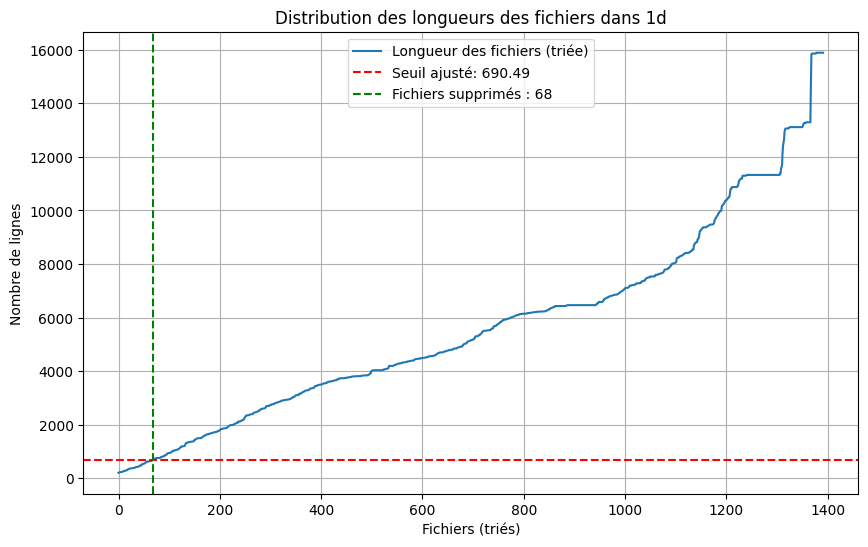

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Dictionnaire global pour stocker les seuils calculés
seuils = {}

def analyze_and_plot_csv_files_by_iqr(data_dir, intervals, iqr_factor=1.5, top_n=10):
    """
    Analyse les fichiers CSV et calcule les seuils IQR par intervalle. Affiche le top-10 des fichiers les plus courts
    et trace les graphiques.

    Args:
        data_dir (str): Dossier contenant les sous-dossiers d'intervalles.
        intervals (list): Liste des sous-dossiers à traiter.
        iqr_factor (float): Facteur pour le calcul du seuil basé sur l'IQR.
        top_n (int): Nombre de fichiers les plus courts à afficher.
    """
    global seuils  # Accès à la variable globale seuils
    
    for interval in intervals:
        folder_path = os.path.join(data_dir, interval)
        if not os.path.exists(folder_path):
            print(f"Le dossier {folder_path} n'existe pas.")
            continue

        print(f"\nTraitement des fichiers dans l'intervalle : {interval}")
        file_stats = []

        # Lecture des fichiers et comptage des lignes
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) and filename.endswith('.csv'):
                try:
                    with open(file_path, 'r') as f:
                        num_lines = sum(1 for _ in f) - 1  # Ignorer l'en-tête
                    file_stats.append((num_lines, filename))
                except Exception as e:
                    print(f"Erreur de lecture du fichier {file_path}: {e}")

        if not file_stats:
            print(f"Aucun fichier valide dans {interval}.")
            continue

        # Calcul des quartiles et IQR
        lengths = np.array([num_lines for num_lines, _ in file_stats])
        Q1 = np.percentile(lengths, 20)
        Q3 = np.percentile(lengths, 75)
        IQR = Q3 - Q1

        # Calcul du seuil basé sur l'IQR
        threshold = Q1 - iqr_factor * IQR
        adjusted_iqr_factor = iqr_factor
        while threshold <= 0 and adjusted_iqr_factor > 0.1:  # Réduire le facteur jusqu'à obtenir un seuil positif
            adjusted_iqr_factor /= 2
            threshold = Q1 - adjusted_iqr_factor * IQR

        if threshold <= 0:  # En dernier recours, utiliser une fraction de Q1
            threshold = Q1 * 0.5
            print(f"Seuil ajusté manuellement à une fraction de Q1 : {threshold:.2f}")

        # Stockage du seuil dans la variable globale
        seuils[interval] = threshold
        print(f"Seuil pour {interval}: {threshold:.2f}")

        # Affichage du top-N des fichiers les plus courts
        file_stats.sort()
        print(f"Top-{top_n} fichiers pour l'intervalle {interval} :")
        for num_lines, filename in file_stats[:top_n]:
            print(f"{filename}: {num_lines} lignes")

        # Calcul du nombre de fichiers à conserver et à supprimer
        files_to_keep = [num_lines for num_lines, _ in file_stats if num_lines >= threshold]
        files_to_delete = [num_lines for num_lines, _ in file_stats if num_lines < threshold]

        print(f"Nombre de fichiers à conserver : {len(files_to_keep)}")
        print(f"Nombre de fichiers à supprimer : {len(files_to_delete)}")

        # Plot des longueurs de fichiers avec le seuil
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(lengths)), np.sort(lengths), label='Longueur des fichiers (triée)')
        plt.axhline(y=threshold, color='red', linestyle='--', label=f'Seuil ajusté: {threshold:.2f}')
        
        # Ajouter une ligne verticale pour séparer les fichiers conservés et supprimés
        plt.axvline(x=len(files_to_delete), color='green', linestyle='--', label=f'Fichiers supprimés : {len(files_to_delete)}')

        plt.title(f'Distribution des longueurs des fichiers dans {interval}')
        plt.xlabel('Fichiers (triés)')
        plt.ylabel('Nombre de lignes')
        plt.legend()
        plt.grid(True)
        plt.show()

# Exemple d'exécution
analyze_and_plot_csv_files_by_iqr(DATA_DIR, INTERVALS, iqr_factor=1.5, top_n=10)


In [8]:
import os
import shutil

def copy_valid_csv_files(data_dir, intervals, seuils, data_dir_enough_data):
    """
    Copie les fichiers CSV dont le nombre de lignes est supérieur au seuil respectif dans un dossier cible.

    Args:
        data_dir (str): Dossier contenant les sous-dossiers d'intervalles.
        intervals (list): Liste des sous-dossiers à traiter.
        seuils (dict): Dictionnaire contenant les seuils calculés pour chaque intervalle.
        data_dir_enough_data (str): Dossier où les fichiers valides seront copiés.
    """
    for interval in intervals:
        folder_path = os.path.join(data_dir, interval)
        if not os.path.exists(folder_path):
            print(f"Le dossier {folder_path} n'existe pas.")
            continue

        # Créer le dossier cible si nécessaire
        target_folder_path = os.path.join(data_dir_enough_data, interval)
        os.makedirs(target_folder_path, exist_ok=True)

        print(f"\nTraitement des fichiers dans l'intervalle : {interval}")

        if interval not in seuils:
            print(f"Aucun seuil trouvé pour l'intervalle {interval}.")
            continue

        threshold = seuils[interval]
        print(f"Seuil pour {interval}: {threshold:.2f}")

        # Lecture des fichiers et comptage des lignes
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) and filename.endswith('.csv'):
                try:
                    with open(file_path, 'r') as f:
                        num_lines = sum(1 for _ in f) - 1  # Ignorer l'en-tête
                    # Si le fichier a plus de lignes que le seuil, le copier
                    if num_lines >= threshold:
                        target_file_path = os.path.join(target_folder_path, filename)
                        shutil.copy(file_path, target_file_path)  # Copier le fichier
                        #print(f"Fichier copié : {file_path} vers {target_file_path} ({num_lines} lignes)")
                except Exception as e:
                    print(f"Erreur de lecture du fichier {file_path}: {e}")

# Exemple d'exécution

DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'  # Dossier cible pour les données suffisamment longues
copy_valid_csv_files(DATA_DIR, INTERVALS, seuils, DATA_DIR_ENOUGH_DATA)



Traitement des fichiers dans l'intervalle : 1d
Seuil pour 1d: 690.49


In [9]:
import os
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'
TECH_DATA_DIR = 'datasets_technicals'
os.makedirs(DATA_DIR_ENOUGH_DATA, exist_ok=True)
os.makedirs(TECH_DATA_DIR, exist_ok=True)

# Liste pour stocker les erreurs
error_list = []


# Fonction pour charger les données en tenant compte du nom de la colonne de date
def load_data(filename):
    """
    Charge les données CSV, supprime les lignes avec des valeurs manquantes avant la première ligne 'Close' renseignée.
    """
    try:
        if os.path.getsize(filename) == 0:
            print(f"Le fichier {filename} est vide.")
            return None

        df = pd.read_csv(filename, parse_dates=['Date'])
        #print(f"Chargement de {filename} réussi. Taille du DataFrame : {df.shape}")

        # Suppression des lignes avant la première ligne valide de 'Close'
        if 'Close' in df.columns:
            first_valid_index = df['Close'].first_valid_index()
            if first_valid_index is not None:
                df = df.loc[first_valid_index:].reset_index(drop=True)
            else:
                print(f"Aucune valeur valide trouvée dans la colonne 'Close' de {filename}.")
                return None

        # S'assurer que 'Date' est l'index
        if 'Date' in df.columns:
            df.set_index('Date', inplace=True)
        return df
    except Exception as e:
        error_list.append((filename, f"Erreur lors du chargement: {str(e)}"))
        print(f"Erreur lors du chargement de {filename}: {e}")
        return None

    
    

    

################### ################### ################### ###################  
    
    
# Optimisation des calculs d'indicateurs
def compute_indicators(df):
    if df is None:
        return None

# RSI14:
    def compute_rsi(series, period=14):
        #Calcule le RSI en s'assurant que la série n'a pas de valeurs manquantes.
        # Supprime les NaN pour éviter des erreurs dans le calcul
        series = series.dropna()
        delta = series.diff()  # Différence entre les prix consécutifs
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()  # Gains
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()  # Pertes
        rs = gain / loss  # Rapport des gains et des pertes
        rsi = 100 - (100 / (1 + rs))  # Calcul du RSI
        # Réindexer pour conserver la structure du DataFrame d'origine
        rsi = rsi.reindex(series.index)
        return rsi
    # Calcul du RSI et ajout au DataFrame
    df['RSI14'] = compute_rsi(df['Close'])


# Stochastiques:
    def compute_stochastic(high, low, close, k_period=14, d_period=3):
        # Supprimez les NaN pour éviter des erreurs dans le calcul
        high, low, close = high.dropna(), low.dropna(), close.dropna()
        lowest_low = low.rolling(window=k_period).min()
        highest_high = high.rolling(window=k_period).max()
        k = 100 * (close - lowest_low) / (highest_high - lowest_low)
        d = k.rolling(window=d_period).mean()
        # Réindexer pour conserver la structure du DataFrame d'origine
        k, d = k.reindex(close.index), d.reindex(close.index)
        return k, d
    df['Stochastic_K14'], df['Stochastic_D14'] = compute_stochastic(
        df['High'], df['Low'], df['Close']
    )

# Mean Reversion Channel:
    rolling_mean = df['Close'].dropna().rolling(window=20).mean().reindex(df.index)
    rolling_std = df['Close'].dropna().rolling(window=20).std().reindex(df.index)
    df['MRC_Upper'] = rolling_mean + 2 * rolling_std
    df['MRC_Lower'] = rolling_mean - 2 * rolling_std

# SMA:
    for period in [10, 20, 50, 100, 200]:
        df[f'SMA{period}'] = df['Close'].dropna().rolling(window=period).mean().reindex(df.index)
        
# EMA:
    def compute_ema(series, span):
        series = series.dropna()
        ema = series.ewm(span=span, adjust=False).mean()
        return ema.reindex(series.index)
    for span in [10, 20, 50]:
        df[f'EMA{span}'] = compute_ema(df['Close'], span)

#Volatility:
    
        # Volatilité :
    def compute_volatility(series, window):
        series = series.dropna()
        return series.pct_change().rolling(window=window).std() * np.sqrt(window)
    for window in [20, 50, 100, 360]:
        df[f'Volatility{window}'] = compute_volatility(df['Close'], window)

        
        
# Paramètres pour le Monte Carlo (méthode de Heston)
    # Calcul des rendements journaliers moyens pour le modèle GBM
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['mu'] = df['log_return'].mean()  # Taux de rendement moyen

    def compute_heston_params(df):
        try:
            volatility_100 = df['Volatility100'].dropna()
            volatility_360 = df['Volatility360'].dropna()

            if len(volatility_100) < 10 or len(volatility_360) < 10:
                return np.nan, np.nan, np.nan

            ema_volatility_100 = volatility_100.ewm(span=100, adjust=False).mean()
            ema_volatility_360 = volatility_360.ewm(span=360, adjust=False).mean()

            theta = np.mean([ema_volatility_100.iloc[-1], ema_volatility_360.iloc[-1]])
            sigma_v = np.std(volatility_360)
            kappa = min(max(1 / np.mean(volatility_360.pct_change().dropna()), 0.1), 10)

            return theta, sigma_v, kappa
        except Exception as e:
            print(f"Error computing Heston params: {e}")
            return np.nan, np.nan, np.nan

    # Calcul des paramètres pour Heston
    theta, sigma_v, kappa = compute_heston_params(df)
    df['theta'] = theta
    df['sigma_v'] = sigma_v
    df['kappa'] = kappa


        
#Momentum(%):
    def compute_momentum(df, periods):
        for period in periods:
            df['Close'] = df['Close'].ffill()  # Remplir les NaN en avant
            df[f'Momentum{period}'] = df['Close'].pct_change(periods=period) * 100
    compute_momentum(df, [20, 50, 100, 252, 360])

            
    return df


################### ################### ################### ###################  





# Fonction pour traiter un ticker et un intervalle
def process_data_for_ticker_and_interval(ticker, interval):
    source_path = os.path.join(DATA_DIR_ENOUGH_DATA, interval, f"{ticker}.csv")
    if not os.path.exists(source_path):
        error_list.append((ticker, interval, "Fichier manquant"))
        #print(f"Fichier manquant pour {ticker} : {source_path}")
        return

    df = load_data(source_path)
    if df is None:
        error_list.append((ticker, interval, "Erreur lors du chargement"))
        return
    df.name = ticker # Assigner un nom au DataFrame

    # Calcul des indicateurs
    df_with_indicators = compute_indicators(df)

    # Sauvegarder les données modifiées dans le sous-dossier TECH_DATA_DIR
    if df_with_indicators is not None:
        destination_path = os.path.join(TECH_DATA_DIR, interval, f"{ticker}.csv")
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        df_with_indicators.to_csv(destination_path)
    else:
        print(f"Aucun indicateur calculé pour {ticker}, DataFrame vide.")


# Traitement parallèle
def process_all_data():
    for interval in INTERVALS:
        print(f"Traitement des données pour l'intervalle : {interval}")

        Parallel(n_jobs=-1)(
            delayed(process_data_for_ticker_and_interval)(ticker, interval)
            for ticker in tqdm(TICKERS, desc=f"Traitement pour {interval}")
        )

    if error_list:
        print("\nErreurs détectées :")
        for ticker, interval, reason in error_list:
            print(f"Ticker: {ticker}, Intervalle: {interval}, Raison: {reason}")
    else:
        print("\nAucune erreur détectée.")


# Lancer le traitement
process_all_data()






Traitement des données pour l'intervalle : 1d


Traitement pour 1d: 100%|██████████| 1549/1549 [01:25<00:00, 18.22it/s]



Aucune erreur détectée.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
DATA_INTERVAL='1d'
def plot_simple_coverage(data_dir, interval):
    """
    Crée un plot simple montrant toutes les dates de tous les fichiers,
    triés par nombre de dates croissant.
    """
    folder_path = os.path.join(data_dir, interval)
    
    # Collecter les informations de dates pour chaque ticker
    ticker_info = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            ticker = filename[:-4]
            df = pd.read_csv(os.path.join(folder_path, filename))
            dates = pd.to_datetime(df['Date'])
            ticker_info.append({
                'ticker': ticker,
                'start': dates.min(),
                'end': dates.max(),
                'count': len(dates)
            })
    
    # Trier par nombre de dates
    ticker_info = sorted(ticker_info, key=lambda x: -x['count'])
    
    plt.figure(figsize=(20, max(10, len(ticker_info)/4)))
    
    # Tracer les lignes dans l'ordre trié
    for i, info in enumerate(ticker_info):
        plt.plot([info['start'], info['end']], [i, i], '-', 
                linewidth=2, label=info['ticker'])
    
    plt.grid(True, alpha=0.3)
    plt.title(f'Couverture temporelle par ticker ({interval})\nTrié par nombre de dates croissant')
    plt.xlabel('Date')
    plt.ylabel('Ticker')
    plt.yticks(range(len(ticker_info)), 
               [f"{info['ticker']} ({info['count']})" for info in ticker_info])
    plt.tight_layout()
    
    return plt.gcf()

# Créer la visualisation
fig = plot_simple_coverage(TECH_DATA_DIR, DATA_INTERVAL)


In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
import time
import random
from tqdm import tqdm 

# Configuration constants
TECH_DATA_DIR = 'datasets_technicals'
DATA_DIR_BACKTEST = 'datasets_backtest'  # Répertoire de sortie pour les fichiers générés
INTERVALS = ['1d']  # Liste des intervalles à traiter
DATA_INTERVAL = '1d'
WINDOWS = [500]

# Variables et paramètres
NUM_RANDOM_STARTS = 30
TRANSACTION_COST = 0.005  # 0,5% de frais de transaction
initial_cash = 10000  # Cash initial de 100 000
purchase_amount = 1000 #Quantité achetée
top_n = 15 #Nombre de top-N winners à maintenir en portefeuille

# Initialize final results list and timer
final_results = []

interval_dates = {}  # Dictionnaire pour stocker les dates min/max de chaque intervalle



# Fonction pour recréer le répertoire DATA_DIR_BACKTEST et ses sous-dossiers
if os.path.exists(DATA_DIR_BACKTEST):
    print(f"Suppression du répertoire existant {DATA_DIR_BACKTEST}...")
    for root, dirs, files in os.walk(DATA_DIR_BACKTEST, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))
    os.rmdir(DATA_DIR_BACKTEST)

print(f"Création du répertoire {DATA_DIR_BACKTEST}...")
os.makedirs(DATA_DIR_BACKTEST, exist_ok=True)
for interval in INTERVALS:
    interval_path = os.path.join(DATA_DIR_BACKTEST, interval)
    os.makedirs(interval_path, exist_ok=True)

# Fonction pour ajouter les dates manquantes pour chaque fichier CSV
def add_missing_dates(file_path, interval, start_date, end_date):
    # Chargement du CSV par morceaux (chunksize) pour les gros fichiers
    chunk_size = 100000  # Ajustez en fonction de la taille des fichiers
    df = pd.read_csv(file_path, dtype={'Date': 'str'}, chunksize=chunk_size)
    full_df = []

    # Traiter les morceaux un par un
    for chunk in df:
        chunk['Date'] = pd.to_datetime(chunk['Date'], errors='coerce', utc=True)
        full_df.append(chunk)

    df = pd.concat(full_df, ignore_index=True)

    interval_mapping = {
        '1m': timedelta(minutes=1),
        '2m': timedelta(minutes=2),
        '5m': timedelta(minutes=5),
        '15m': timedelta(minutes=15),
        '30m': timedelta(minutes=30),
        '1h': timedelta(minutes=30),
        '3h': timedelta(hours=3),
        '6h': timedelta(hours=6),
        '12h': timedelta(hours=12),
        '1d': timedelta(days=1)
    }
    
    delta = interval_mapping.get(interval)
    if not delta:
        print(f"Intervalle {interval} non pris en charge.")
        return

    # Créer la plage de dates manquantes
    #if interval == '1d':
    #    all_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' exclut samedis et dimanches
    #else:
    all_dates = pd.date_range(start=start_date, end=end_date, freq=delta)

    # Créer un DataFrame avec les dates manquantes
    full_dates_df = pd.DataFrame(all_dates, columns=['Date'])
    full_dates_df['Date'] = pd.to_datetime(full_dates_df['Date'], utc=True)

    # Fusionner les DataFrames (dates manquantes + données originales)
    df_full = pd.merge(full_dates_df, df, on='Date', how='left')

    # Identifier les colonnes numériques pour l'interpolation
    cols_to_interpolate = df_full.select_dtypes(include=['float64', 'int64']).columns.tolist()
    cols_to_interpolate = [col for col in cols_to_interpolate if col != 'Volume']  # Ne pas interpoler 'Volume'

    # Interpolation linéaire sur les colonnes numériques
    df_full[cols_to_interpolate] = df_full[cols_to_interpolate].interpolate(method='linear', limit=1)

    # Exclure l'interpolation sur les samedis
    saturdays = df_full['Date'].dt.weekday == 5  # 5 = samedi
    df_full.loc[saturdays, cols_to_interpolate] = pd.NA

    # Créer le répertoire final pour cet intervalle si nécessaire
    interval_folder = os.path.join(DATA_DIR_BACKTEST, interval)
    os.makedirs(interval_folder, exist_ok=True)

    # Sauvegarder le fichier complété
    output_file = os.path.join(interval_folder, os.path.basename(file_path))
    if os.path.basename(file_path).replace('.csv', '') not in TICKERS:
        return  # Si le fichier n'est pas dans TICKERS, ne pas enregistrer
    df_full.to_csv(output_file, index=False)


# Fonction pour obtenir les dates maximales et minimales pour un intervalle
def get_aggregated_summary(data_dir, interval, target_date=None):
    if interval in interval_dates:
        return interval_dates[interval]

    folder_path = os.path.join(data_dir, interval)
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist.")
        return None, None

    max_first_date = None
    min_last_date = None

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith('.csv'):
            df = pd.read_csv(file_path)
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
                file_first_date = df['Date'].iloc[0]
                file_last_date = df['Date'].iloc[-1]

                if max_first_date is None or file_first_date > max_first_date:
                    max_first_date = file_first_date
                if min_last_date is None or file_last_date < min_last_date:
                    min_last_date = file_last_date

    # Ajuster la plage pour inclure la date cible
    if target_date:
        target_date = pd.to_datetime(target_date, errors='coerce', utc=True)
        if target_date < max_first_date:
            max_first_date = target_date
        if target_date > min_last_date:
            print(f"La date cible {target_date.date()} est hors de la plage des données.")
            return None, None

    interval_dates[interval] = (max_first_date, min_last_date)
    return max_first_date, min_last_date

# Fonction pour vérifier si un fichier contient une date prédéfinie (entre la première et la dernière date)
def file_contains_date(file_path, target_date):
    df = pd.read_csv(file_path)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
        
        # Convertir la target_date en Timestamp pour la comparaison
        target_date = pd.to_datetime(target_date, utc=True)

        # Récupérer la première et dernière date du fichier
        file_first_date = df['Date'].iloc[0]
        file_last_date = df['Date'].iloc[-1]

        # Comparer la date cible avec la plage du fichier
        if file_first_date <= target_date <= file_last_date:
            return True
    return False


# Fonction pour traiter un fichier CSV
def process_file(file_path, interval, start_date, end_date):
    add_missing_dates(file_path, interval, start_date, end_date)

# Filtrer et traiter les fichiers en fonction de l'intervalle et de la date cible
def process_files_for_interval(interval, target_date=None):
    start_date, end_date = get_aggregated_summary(TECH_DATA_DIR, interval, target_date)

    if start_date and end_date:
        files_to_process = []
        for root, dirs, files in os.walk(TECH_DATA_DIR):
            for file in files:
                if file.endswith('.csv') and interval in root and file.replace('.csv', '') in TICKERS:
                    file_path = os.path.join(root, file)
                    if not target_date or file_contains_date(file_path, target_date):
                        files_to_process.append(file_path)

        with ThreadPoolExecutor() as executor:
            with tqdm(total=len(files_to_process), desc=f"Traitement des fichiers pour {interval}", unit="fichier") as pbar:
                for _ in executor.map(lambda file_path: process_file(file_path, interval, start_date, end_date),
                                       files_to_process):
                    pbar.update(1)

        # Calcul de la taille de la fenêtre (max_window_size)
        max_window_size = (end_date - start_date).days
        print(f"Max window size pour {interval}: {max_window_size} jours")

        return max_window_size  # Retourner la taille de la fenêtre pour utilisation ultérieure


# Fonction de simulation des trades
def process_trades(window, start, start_position, end_position, available_capital, TRANSACTION_COST):
    dfs = {}
    for ticker in TICKERS:
        file_path = f"{DATA_DIR_BACKTEST}/{DATA_INTERVAL}/{ticker}.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, 
                           skiprows=range(1, start_position + 1), 
                           nrows=window)
            if not df.empty:
                dfs[ticker] = df

    if not dfs:
        return []

    nb_periods = window
    tickers = list(dfs.keys())
    
    positions = np.zeros((nb_periods, len(tickers)), dtype=np.float32)
    cash = np.full(nb_periods, available_capital, dtype=np.float32)
    price_matrix = np.full((nb_periods, len(tickers)), np.nan, dtype=np.float32)
    momentum_matrix = np.full((nb_periods, len(tickers)), np.nan, dtype=np.float32)

    # Lists to store position changes
    bought_tickers = []
    sold_tickers = []
    held_tickers = []

    for idx, ticker in enumerate(tickers):
        close_prices = dfs[ticker]['Close'].ffill()
        momentum_values = dfs[ticker]['Momentum252'].ffill()
        price_matrix[:, idx] = close_prices.values
        momentum_matrix[:, idx] = momentum_values.values

    for i in range(nb_periods):
        period_bought = []
        period_sold = []
        period_held = []
        
        if i > 0:
            positions[i] = positions[i-1]
            cash[i] = cash[i-1]

        valid_mask = ~np.isnan(momentum_matrix[i]) & ~np.isnan(price_matrix[i])
        if not np.any(valid_mask):
            bought_tickers.append(period_bought)
            sold_tickers.append(period_sold)
            held_tickers.append(period_held)
            continue

        valid_momentum = np.where(valid_mask, momentum_matrix[i], -np.inf)
        top_indices = np.argsort(valid_momentum)[-top_n:]

        # Track sells
        positions_held = positions[i] > 0
        sell_mask = positions_held & ~np.isin(np.arange(len(tickers)), top_indices)
        
        for idx in np.where(sell_mask)[0]:
            if valid_mask[idx]:
                sale_value = positions[i, idx] * price_matrix[i, idx]
                cash[i] += sale_value * (1 - TRANSACTION_COST)
                positions[i, idx] = 0
                period_sold.append(tickers[idx])

        # Track buys
        current_positions = np.sum(positions[i] > 0)
        remaining_slots = top_n - current_positions

        if remaining_slots > 0:
            available_top = [idx for idx in top_indices if positions[i, idx] == 0 and valid_mask[idx]]

            for idx in available_top[:remaining_slots]:
                if cash[i] >= purchase_amount * (1 + TRANSACTION_COST):
                    shares = purchase_amount / price_matrix[i, idx]
                    positions[i, idx] = shares
                    cash[i] -= purchase_amount * (1 + TRANSACTION_COST)
                    period_bought.append(tickers[idx])

        # Track held positions
        for idx in range(len(tickers)):
            if positions[i, idx] > 0:
                period_held.append(tickers[idx])

        bought_tickers.append(period_bought)
        sold_tickers.append(period_sold)
        held_tickers.append(period_held)

    portfolio_values = np.sum(positions * price_matrix, axis=1) + cash
    
    results = []
    for idx, ticker in enumerate(tickers):
        df = pd.DataFrame({
            'portfolio_value': portfolio_values,
            'window': window,
            'ticker': ticker,
            'start': start,
            'period': np.arange(nb_periods),
            'Date': dfs[ticker]['Date'],
            'start_position': start_position,
            'end_position': end_position,
            'shares': positions[:, idx],
            'Close': price_matrix[:, idx],
            'cash': cash,
            'return_365': momentum_matrix[:, idx],
            'BOUGHT_TICKERS': bought_tickers,
            'SOLD_TICKERS': sold_tickers,
            'HELD_TICKERS': held_tickers
        })
        results.append(df)
    
    return results

# Entrée utilisateur : date cible ou plage commune par défaut
target_date_str = input("Veuillez entrer une date au format yyyy-mm-dd (laisser vide pour une plage commune auto.) : ")
target_date = None

if target_date_str:
    try:
        target_date = datetime.strptime(target_date_str, "%Y-%m-%d").date()
    except ValueError:
        print("Format de date invalide. Veuillez entrer une date au format yyyy-mm-dd.")
        exit()


start_time = time.time()
# Calcul de la taille de la fenêtre max pour chaque intervalle, une seule fois
max_window_size = process_files_for_interval(INTERVALS[0], target_date)  # Par exemple, prendre le premier intervalle
print(f"\nExecution time: {time.time() - start_time:.2f} seconds")
start_time = time.time()

# Traiter les différents Windows
for window in WINDOWS:
    if window > max_window_size:
        warnings.warn(f"Window size {window} exceeds maximum possible length ({max_window_size})")
        continue

    with ThreadPoolExecutor(max_workers=5 * os.cpu_count()) as executor:
        futures = []  # Liste pour stocker les objets futures
        pbar = tqdm(total=len(WINDOWS) * NUM_RANDOM_STARTS, desc="Processing tasks", ncols=100)
        
        # Boucle sur les starts
        for start in range(NUM_RANDOM_STARTS):
            end_position = random.randint(window, max_window_size)
            start_position = end_position - window
            
            # Soumettre la tâche au ThreadPoolExecutor
            futures.append(executor.submit(process_trades, window, start, start_position, end_position, initial_cash, TRANSACTION_COST))
        
        # Collecte des résultats une fois que les tâches sont terminées
        final_results = []
        for future in as_completed(futures):
            result = future.result()  # Récupérer le résultat de la tâche
            final_results.extend(result)  # Ajouter les résultats au final
            pbar.update(1)  # Mise à jour de la barre de progression pour chaque tâche terminée
        
        pbar.close()  # Fermer la barre de progression

# Process results
final_df = pd.concat(final_results)
final_df = final_df.sort_values(by=['window', 'start', 'period', 'ticker'])
final_df['nb_tickers_held'] = (
    final_df.groupby(['window', 'start', 'period'])['shares']
    .transform(lambda x: (x != 0).sum())
)

# Afficher les résultats finaux
print(f"\nExecution time: {time.time() - start_time:.2f} seconds")


# Préparer une palette de couleurs pour les différents starts
import matplotlib.pyplot as plt
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, NUM_RANDOM_STARTS))  # Génère un ensemble de couleurs pour les starts
plt.figure(figsize=(20, 10))
for i, window in enumerate(WINDOWS):
    window_df = final_df[final_df['window'] == window]  # Filtrer pour chaque fenêtre
    for j, start in enumerate(window_df['start'].unique()):
        start_df = window_df[window_df['start'] == start]
        plt.plot(start_df['period'], start_df['portfolio_value'], 
                 label=f"Window {window} Start {start}", 
                 color=colors[j],  # Couleur spécifique à chaque start
                 alpha=0.2)  # Transparence uniforme
        # Ajouter une annotation à la fin de la courbe
        last_period = start_df['period'].iloc[-1]
        last_value = start_df['portfolio_value'].iloc[-1]
        plt.text(last_period, last_value, f"W{window} S{start}", 
                 color=colors[j], fontsize=10, fontweight='bold')
plt.xlabel('Période (Index de la période)')
plt.ylabel('Valeur du portefeuille')
plt.title('Évolution de la valeur du portefeuille par fenêtre et par start')
#plt.legend(title='Fenêtre et Start', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



# Créer un 2ème graphique pour la synthèse des résultats
# Calcul des statistiques
mean_values = final_df.groupby(['window', 'period'])['portfolio_value'].mean()
q1_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.25)
q2_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.5)
q3_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.75)
p5_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.05)
p95_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.95)
p10_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.10)
p90_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.90)
min_values = final_df.groupby(['window', 'period'])['portfolio_value'].min()
max_values = final_df.groupby(['window', 'period'])['portfolio_value'].max()

# Création du graphique
plt.figure(figsize=(20, 10))
for i, window in enumerate(WINDOWS):
    window_mean = mean_values[window]
    window_q1 = q1_values[window]
    window_q2 = q2_values[window]
    window_q3 = q3_values[window]
    window_p5 = p5_values[window]
    window_p95 = p95_values[window]
    window_p10 = p10_values[window]
    window_p90 = p90_values[window]
    window_min = min_values[window]
    window_max = max_values[window]
    # Canal valeurs extrêmes (min et max)
    plt.fill_between(window_min.index, window_min.values, window_max.values, 
                     color='DarkSlateBlue', alpha=1, label=f"Min/Max W{window}")
    # Canal 5% - 95% (p5 et p95)
    plt.fill_between(window_p5.index, window_p5.values, window_p95.values, 
                     color='Salmon', alpha=1, label=f"5-95% W{window}")
    # Canal 5% - 95% (p5 et p95)
    plt.fill_between(window_p5.index, window_p10.values, window_p90.values, 
                     color='Pink', alpha=1, label=f"10-90% W{window}")
    # Canal quartiles (Q1 et Q3)
    plt.fill_between(window_q1.index, window_q1.values, window_q3.values, 
                     color='PeachPuff', alpha=1, label=f"25-75% W{window}")
    # Médiane
    plt.plot(window_q2.index, window_q2.values, label=f"Médiane W{window}", 
             color='DarkSlateGray', linewidth=2, alpha=0.8)
    # Moyenne
    plt.plot(window_mean.index, window_mean.values, label=f"Moyenne W{window}", 
             color='black', linewidth=3, alpha=0.8)
# Ajouter les axes, titre et labels
plt.xlabel('Période (Index de la période)')
plt.ylabel('Valeur du portefeuille')
plt.title('Résumé des résultats : Moyenne, Quartiles, Min/Max par fenêtre')
# Ajuster la disposition et éviter les chevauchements
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='center')  # Légende supprimée
plt.grid(True)
plt.show()


final_df.tail(20)


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandas.tseries.holiday import USFederalHolidayCalendar, AbstractHolidayCalendar, Holiday, GoodFriday
from pandas.tseries.offsets import CustomBusinessDay
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption Day', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas', month=12, day=25)
    ]

def load_data(data_dir):
    """Load all CSV files from directory and combine them into a panel."""
    print("Chargement des données...")
    data = {}
    files = list(Path(data_dir).glob('*.csv'))
    for file in tqdm(files, desc="Chargement des fichiers CSV"):
        ticker = file.stem
        df = pd.read_csv(file)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        data[ticker] = df
    return data

def create_trading_calendar(start_date, end_date):
    """Create trading calendar excluding US and French holidays."""
    us_cal = USFederalHolidayCalendar()
    fr_cal = FrenchHolidayCalendar()
    
    us_holidays = us_cal.holidays(start=start_date, end=end_date)
    fr_holidays = fr_cal.holidays(start=start_date, end=end_date)
    all_holidays = us_holidays.union(fr_holidays)
    
    bday = CustomBusinessDay(holidays=all_holidays)
    trading_days = pd.date_range(start=start_date, end=end_date, freq=bday)
    
    return trading_days

def get_daily_summary(portfolio, holdings, transactions, data, date):
    """Get summary of portfolio state for a specific date."""
    summary = pd.Series({
        'Cash': portfolio.loc[date, 'cash'],
        'Portfolio Value': portfolio.loc[date, 'portfolio_value'],
        'Tickers Held': ', '.join([t for t in holdings.columns if holdings.loc[date, t] > 0]),
        'Tickers Bought': transactions.loc[date, 'bought'],
        'Tickers Sold': transactions.loc[date, 'sold']
    })
    
    for ticker in holdings.columns:
        if holdings.loc[date, ticker] > 0 and date in data[ticker].index:
            value = holdings.loc[date, ticker] * data[ticker].loc[date, 'Close']
            summary[f'{ticker} Value'] = value
    
    return summary

def backtest_momentum_strategy(data_dir, initial_cash=100000, position_size=1000, transaction_fee_pct=0.005):
    print("\nDémarrage du backtest...")
    data = load_data(data_dir)
    
    start_date = max(df.index.min() for df in data.values())
    end_date = min(df.index.max() for df in data.values())
    trading_days = create_trading_calendar(start_date, end_date)
    
    portfolio = pd.DataFrame(index=trading_days, columns=['cash', 'portfolio_value'])
    portfolio['cash'] = initial_cash
    holdings = pd.DataFrame(0.0, index=trading_days, columns=data.keys())
    transactions = pd.DataFrame(index=trading_days, columns=['bought', 'sold'])
    
    print(f"Période de backtest : {start_date.date()} - {end_date.date()}")
    print(f"Nombre de jours de trading : {len(trading_days)}")
    
    for date in tqdm(trading_days, desc="Progression du backtest"):
        available_tickers = []
        momentum_values = {}
        volumes = {}
        
        for ticker, df in data.items():
            if date in df.index:
                momentum_values[ticker] = df.loc[date, 'Momentum252']
                volumes[ticker] = df.loc[date, 'Volume']
                available_tickers.append(ticker)
        
        if not available_tickers:
            continue
            
        volume_threshold = np.percentile(list(volumes.values()), 90)
        valid_tickers = [t for t in available_tickers if volumes[t] >= volume_threshold]
        momentum_sorted = sorted([(t, momentum_values[t]) for t in valid_tickers],
                               key=lambda x: x[1], reverse=True)
        
        top_10 = [t[0] for t in momentum_sorted[:10]]
        prev_holdings = holdings.loc[portfolio.index[portfolio.index < date][-1]] if date != trading_days[0] else pd.Series(0, index=holdings.columns)
        
        to_sell = [t for t in prev_holdings.index[prev_holdings > 0] if t not in top_10]
        cash_available = portfolio.loc[portfolio.index[portfolio.index < date][-1], 'cash'] if date != trading_days[0] else initial_cash
        to_buy = [t for t in top_10 if prev_holdings[t] == 0]
        
        for ticker in to_sell:
            if date in data[ticker].index:
                shares = prev_holdings[ticker]
                value = shares * data[ticker].loc[date, 'Close']
                cash_available += value * (1 - transaction_fee_pct)
                prev_holdings[ticker] = 0
        
        for ticker in to_buy:
            if cash_available >= position_size and date in data[ticker].index:
                shares = position_size / data[ticker].loc[date, 'Close']
                shares = shares * (1 - transaction_fee_pct)
                prev_holdings[ticker] = shares
                cash_available -= position_size
        
        holdings.loc[date] = prev_holdings
        
        portfolio_value = cash_available
        for ticker in holdings.columns:
            if date in data[ticker].index:
                portfolio_value += holdings.loc[date, ticker] * data[ticker].loc[date, 'Close']
        
        portfolio.loc[date, 'cash'] = cash_available
        portfolio.loc[date, 'portfolio_value'] = portfolio_value
        
        transactions.loc[date, 'bought'] = ', '.join(to_buy) if to_buy else ''
        transactions.loc[date, 'sold'] = ', '.join(to_sell) if to_sell else ''
    
    print("\nBacktest terminé !")
    return portfolio, holdings, transactions

# Utilisation
data_dir = "datasets_technicals/1d"
portfolio, holdings, transactions = backtest_momentum_strategy(data_dir)

# Création des résultats journaliers
data = load_data(data_dir)  # Data déjà chargée durant le backtest, mais nécessaire pour get_daily_summary
daily_summaries = []
for date in tqdm(portfolio.index, desc="Création du rapport"):
    daily_summaries.append(get_daily_summary(portfolio, holdings, transactions, data, date))
results_backtest = pd.DataFrame(daily_summaries)
results_backtest
#results_backtest.to_csv('results_backtest.csv')

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandas.tseries.holiday import USFederalHolidayCalendar, AbstractHolidayCalendar, Holiday, GoodFriday
from pandas.tseries.offsets import CustomBusinessDay
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption Day', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas', month=12, day=25)
    ]

def load_data(data_dir):
    """Load all CSV files from directory and combine them into a panel."""
    print("Chargement des données...")
    data = {}
    files = list(Path(data_dir).glob('*.csv'))
    for file in tqdm(files, desc="Chargement des fichiers CSV"):
        ticker = file.stem
        df = pd.read_csv(file)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        data[ticker] = df
    return data

def create_trading_calendar(start_date, last_available_date):
    """Create trading calendar excluding US and French holidays."""
    us_cal = USFederalHolidayCalendar()
    fr_cal = FrenchHolidayCalendar()
    
    us_holidays = us_cal.holidays(start=start_date, end=last_available_date)
    fr_holidays = fr_cal.holidays(start=start_date, end=last_available_date)
    all_holidays = us_holidays.union(fr_holidays)
    
    bday = CustomBusinessDay(holidays=all_holidays)
    trading_days = pd.date_range(start=start_date, end=last_available_date, freq=bday)
    
    return trading_days

def get_daily_summary(portfolio, holdings, transactions, data, date):
    """Get summary of portfolio state for a specific date."""
    summary = pd.Series({
        'Cash': portfolio.loc[date, 'cash'],
        'Portfolio Value': portfolio.loc[date, 'portfolio_value'],
        'Tickers Held': ', '.join([t for t in holdings.columns if holdings.loc[date, t] > 0]),
        'Tickers Bought': transactions.loc[date, 'bought'],
        'Tickers Sold': transactions.loc[date, 'sold']
    })
    
    for ticker in holdings.columns:
        if holdings.loc[date, ticker] > 0 and date in data[ticker].index:
            value = holdings.loc[date, ticker] * data[ticker].loc[date, 'Close']
            summary[f'{ticker} Value'] = value
    
    return summary

def find_first_available_date(data, requested_start_date):
    """Find the first date where we have data for at least one ticker."""
    all_dates = sorted(set().union(*[df.index for df in data.values()]))
    valid_dates = [date for date in all_dates if date >= requested_start_date]
    return valid_dates[0] if valid_dates else None

def backtest_momentum_strategy(data_dir, start_date, initial_cash=100000, position_size=1000, transaction_fee_pct=0.005):
    print("\nDémarrage du backtest...")
    data = load_data(data_dir)
    
    # Convert start_date to datetime if string
    start_date = pd.to_datetime(start_date)
    
    # Find the first available date after the requested start date
    actual_start_date = find_first_available_date(data, start_date)
    if actual_start_date is None:
        raise ValueError("Aucune donnée disponible après la date de début demandée")
    
    # Find the last available date across all data
    last_available_date = max(df.index.max() for df in data.values())
    
    # Create trading calendar
    trading_days = create_trading_calendar(actual_start_date, last_available_date)
    
    portfolio = pd.DataFrame(index=trading_days, columns=['cash', 'portfolio_value'])
    portfolio['cash'] = initial_cash
    holdings = pd.DataFrame(0.0, index=trading_days, columns=data.keys())
    transactions = pd.DataFrame(index=trading_days, columns=['bought', 'sold'])
    
    print(f"Date de début demandée : {start_date.date()}")
    print(f"Date de début effective : {actual_start_date.date()}")
    print(f"Date de fin (dernière donnée disponible) : {last_available_date.date()}")
    print(f"Nombre de jours de trading : {len(trading_days)}")
    
    for date in tqdm(trading_days, desc="Progression du backtest"):
        available_tickers = []
        momentum_values = {}
        volumes = {}
        
        # Get data for tickers available on this date
        for ticker, df in data.items():
            if date in df.index:
                momentum_values[ticker] = df.loc[date, 'Momentum252']
                volumes[ticker] = df.loc[date, 'Volume']
                available_tickers.append(ticker)
        
        if not available_tickers:
            print(f"\nAucun ticker disponible pour la date {date.date()}, passage à la date suivante")
            continue
            
        print(f"\rNombre de tickers disponibles pour {date.date()}: {len(available_tickers)}", end="")
        
        volume_threshold = np.percentile(list(volumes.values()), 90)
        valid_tickers = [t for t in available_tickers if volumes[t] >= volume_threshold]
        momentum_sorted = sorted([(t, momentum_values[t]) for t in valid_tickers],
                               key=lambda x: x[1], reverse=True)
        
        top_10 = [t[0] for t in momentum_sorted[:10]]
        prev_holdings = holdings.loc[portfolio.index[portfolio.index < date][-1]] if date != trading_days[0] else pd.Series(0, index=holdings.columns)
        
        to_sell = [t for t in prev_holdings.index[prev_holdings > 0] if t not in top_10]
        cash_available = portfolio.loc[portfolio.index[portfolio.index < date][-1], 'cash'] if date != trading_days[0] else initial_cash
        to_buy = [t for t in top_10 if prev_holdings[t] == 0]
        
        for ticker in to_sell:
            if date in data[ticker].index:
                shares = prev_holdings[ticker]
                value = shares * data[ticker].loc[date, 'Close']
                cash_available += value * (1 - transaction_fee_pct)
                prev_holdings[ticker] = 0
        
        for ticker in to_buy:
            if cash_available >= position_size and date in data[ticker].index:
                shares = position_size / data[ticker].loc[date, 'Close']
                shares = shares * (1 - transaction_fee_pct)
                prev_holdings[ticker] = shares
                cash_available -= position_size
        
        holdings.loc[date] = prev_holdings
        
        portfolio_value = cash_available
        for ticker in holdings.columns:
            if date in data[ticker].index:
                portfolio_value += holdings.loc[date, ticker] * data[ticker].loc[date, 'Close']
        
        portfolio.loc[date, 'cash'] = cash_available
        portfolio.loc[date, 'portfolio_value'] = portfolio_value
        
        transactions.loc[date, 'bought'] = ', '.join(to_buy) if to_buy else ''
        transactions.loc[date, 'sold'] = ', '.join(to_sell) if to_sell else ''
    
    print("\nBacktest terminé !")
    return portfolio, holdings, transactions

# Utilisation
data_dir = "datasets_technicals/1d"
start_date = "2010-01-01"  # À modifier selon vos besoins
portfolio, holdings, transactions = backtest_momentum_strategy(data_dir, start_date)

# Création des résultats journaliers
data = load_data(data_dir)
daily_summaries = []
for date in tqdm(portfolio.index, desc="Création du rapport"):
    daily_summaries.append(get_daily_summary(portfolio, holdings, transactions, data, date))
results_backtest = pd.DataFrame(daily_summaries)
results_backtest
#results_backtest.to_csv('results_backtest.csv')

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandas.tseries.holiday import USFederalHolidayCalendar, AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import CustomBusinessDay
from numba import jit
import warnings

warnings.filterwarnings('ignore')

class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption Day', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas', month=12, day=25)
    ]

def load_data(data_dir):
    files = Path(data_dir).glob('*.csv')
    return {
        f.stem: pd.read_csv(f, parse_dates=['Date'], index_col='Date')
        for f in files
    }

def create_trading_calendar(start, end):
    us_cal = USFederalHolidayCalendar()
    fr_cal = FrenchHolidayCalendar()
    holidays = us_cal.holidays(start, end).union(fr_cal.holidays(start, end))
    return pd.date_range(start, end, freq=CustomBusinessDay(holidays=holidays))

@jit(nopython=True)
def calculate_position_changes(prev_holdings, top_10_mask, close_prices, cash, position_size, fee_rate):
    new_holdings = prev_holdings.copy()
    total_fees = 0.0
    
    # Vendre les positions sortantes
    for i in range(len(prev_holdings)):
        if prev_holdings[i] > 0 and not top_10_mask[i]:
            sale_value = prev_holdings[i] * close_prices[i]
            cash += sale_value * (1 - fee_rate)
            total_fees += sale_value * fee_rate
            new_holdings[i] = 0.0
    
    # Acheter les nouvelles positions
    buy_candidates = np.where(top_10_mask & (prev_holdings == 0))[0]
    for i in buy_candidates:
        if cash >= position_size:
            shares = position_size / close_prices[i]
            cash -= position_size
            total_fees += position_size * fee_rate
            new_holdings[i] = shares
    
    return new_holdings, cash, total_fees

def optimized_backtest(data, trading_days, initial_cash=100000, position_size=1000, fee_rate=0.005):
    close = pd.DataFrame({t: df['Close'].reindex(trading_days) for t, df in data.items()})
    volume = pd.DataFrame({t: df['Volume'].reindex(trading_days) for t, df in data.items()})
    momentum = pd.DataFrame({t: df['Momentum252'].reindex(trading_days) for t, df in data.items()})
    
    holdings = pd.DataFrame(0.0, index=trading_days, columns=close.columns)
    portfolio = pd.DataFrame({
        'cash': initial_cash,
        'fees': 0.0,
        'portfolio_value': initial_cash
    }, index=trading_days)

    for i in range(1, len(trading_days)):
        date = trading_days[i]
        prev_date = trading_days[i-1]
        
        # Filtrer d'abord les NaN
        valid_data = ~np.isnan(momentum.loc[date]) & ~np.isnan(volume.loc[date])
        
        # Appliquer le filtre de volume sur les données valides
        vol_threshold = np.nanpercentile(volume.loc[date][valid_data], 50)
        volume_filter = (volume.loc[date] >= vol_threshold) & valid_data
        
        # Calculer le ranking uniquement sur les titres valides et passant le filtre de volume
        mom_rank = momentum.loc[date][volume_filter].rank(ascending=False)
        top_10 = pd.Series(False, index=close.columns)
        top_10[mom_rank[mom_rank <= 10].index] = True
        
        # Calcul des changements de position avec gestion symétrique des frais
        new_holdings, new_cash, fees = calculate_position_changes(
            holdings.loc[prev_date].values,
            top_10.values,
            close.loc[date].values,
            portfolio.loc[prev_date, 'cash'],
            position_size,
            fee_rate
        )
        
        holdings.loc[date] = new_holdings
        holdings_value = (holdings.loc[date] * close.loc[date]).sum()
        portfolio.loc[date, 'cash'] = new_cash
        portfolio.loc[date, 'fees'] = portfolio.loc[prev_date, 'fees'] + fees
        portfolio.loc[date, 'portfolio_value'] = new_cash + holdings_value
        
    return portfolio, holdings

# Utilisation
data_dir = "datasets_technicals/1d"
start_date = "2020-01-01"
trading_days = create_trading_calendar(start_date, max(df.index.max() for df in data.values()))
portfolio, holdings = optimized_backtest(data, trading_days)
portfolio.tail(40)

import matplotlib.pyplot as plt
import seaborn as sns
results_backtest
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(pd.to_datetime(portfolio.index), portfolio['portfolio_value'])
plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def create_detailed_report(portfolio, holdings, data, trading_days):
    close = pd.DataFrame({t: df['Close'].reindex(trading_days) for t, df in data.items()})
    
    # Initialisation du DataFrame résultat
    report = pd.DataFrame(index=trading_days)
    
    # Ajout des informations de base
    report['Cash'] = portfolio['cash']
    report['Portfolio Value'] = portfolio['portfolio_value']
    report['Daily Fees'] = portfolio['fees']
    report['Cumulative Fees'] = portfolio['fees'].cumsum()
    
    # Calcul des valeurs par position
    ticker_values = holdings * close
    report['Total Holdings Value'] = ticker_values.sum(axis=1)
    
    # Ajout des valeurs individuelles des tickers détenus
    for ticker in holdings.columns:
        mask = holdings[ticker] > 0
        if mask.any():
            report[f'{ticker} Value'] = ticker_values[ticker]
    
    # Identification des tickers détenus, achetés et vendus par date
    report['Tickers Held'] = holdings.apply(
        lambda x: ', '.join(sorted(x.index[x > 0].tolist())), axis=1
    )
    
    # Calcul des transactions (différences entre deux jours consécutifs)
    holdings_diff = holdings.diff()
    report['Tickers Bought'] = holdings_diff.apply(
        lambda x: ', '.join(sorted(x.index[x > 0].tolist())), axis=1
    )
    report['Tickers Sold'] = holdings_diff.apply(
        lambda x: ', '.join(sorted(x.index[x < 0].tolist())), axis=1
    )
    
    # Réorganisation des colonnes pour une meilleure lisibilité
    base_cols = [
        'Cash',
        'Total Holdings Value',
        'Portfolio Value',
        'Daily Fees',
        'Cumulative Fees',
        'Tickers Held',
        'Tickers Bought',
        'Tickers Sold'
    ]
    value_cols = [col for col in report.columns if col.endswith(' Value') 
                 and col != 'Portfolio Value' 
                 and col != 'Total Holdings Value']
    
    report = report[base_cols + sorted(value_cols)]
    
    return report

# Utilisation
detailed_report = create_detailed_report(portfolio, holdings, data, trading_days)
# Pour voir toutes les informations d'une date spécifique
detailed_report.head(666)

# Pour voir l'évolution d'une métrique dans le temps
#detailed_report['Portfolio Value'].plot()

In [ ]:
## Filtrer le DataFrame pour obtenir les résultats pour ticker='TSLA' et start=1
filtered_df = final_df[ (final_df['start'] >-1) & (final_df['period'] == 499) ]
filtered_df.to_csv('filtered_results.csv', index=False)
## Sauvegarde des résultats
#final_df.to_csv('total_results.csv', index=False)

In [ ]:
def analyze_daily_positions(df):
    # Sort by date to ensure proper analysis
    df = df.sort_values(['Date', 'ticker'])
    
    # Create initial groupby object
    daily_group = df.groupby('Date')
    
    # Get basic daily metrics
    daily_metrics = daily_group.agg({
        'nb_tickers_held': 'first',
        'portfolio_value': 'first',
        'cash': 'first'
    }).reset_index()
    
    # Function to get tickers with positions
    def get_held_tickers(group):
        return ','.join(group[group['shares'] > 0]['ticker'].tolist())
    
    # Add held tickers
    daily_metrics['tickers_held'] = daily_group.apply(get_held_tickers)
    
    # Get previous day's positions for comparison
    df['prev_shares'] = df.groupby('ticker')['shares'].shift(1).fillna(0)
    
    # Identify bought and sold tickers
    def get_position_changes(group):
        bought = group[((group['shares'] > 0) & (group['prev_shares'] == 0))]['ticker'].tolist()
        sold = group[((group['shares'] == 0) & (group['prev_shares'] > 0))]['ticker'].tolist()
        return pd.Series({
            'tickers_bought': ','.join(bought),
            'tickers_sold': ','.join(sold)
        })
    
    # Add position changes
    position_changes = daily_group.apply(get_position_changes)
    daily_metrics = daily_metrics.join(position_changes)
    
    return daily_metrics

# Create the summary dataframe
summary_df = analyze_daily_positions(final_df)
summary_df

In [ ]:
# Charger les données du taux sans risque depuis le fichier CSV
riskfreerate = pd.read_csv('RISK_FREE_TICKER.csv')

# Convertir la colonne 'Date' en datetime sans UTC
riskfreerate['Date'] = pd.to_datetime(riskfreerate['Date'], utc=False)

# Créer une colonne Date_for_merge dans riskfreerate (sans l'heure)
riskfreerate['Date_for_merge'] = riskfreerate['Date'].dt.strftime('%Y-%m-%d')  # Seuls les jours
riskfreerate['Date_for_merge'] = pd.to_datetime(riskfreerate['Date_for_merge'], format='%Y-%m-%d')

sharpe_ratio_per_start_df = final_df[['window', 'start', 'period', 'Date', 'portfolio_value', 'nb_tickers_held']].copy().drop_duplicates()

# Convertir la colonne 'Date' en datetime si ce n'est déjà fait
sharpe_ratio_per_start_df['Date'] = pd.to_datetime(sharpe_ratio_per_start_df['Date'], errors='coerce')

# Effectuer la jointure sur la colonne Date_for_merge
sharpe_ratio_per_start_df['Date'] = sharpe_ratio_per_start_df['Date'].dt.tz_localize(None)
sharpe_ratio_per_start_df['Date_for_merge'] = sharpe_ratio_per_start_df['Date'].dt.strftime('%Y-%m-%d')  # Seuls les jours
sharpe_ratio_per_start_df['Date_for_merge'] = pd.to_datetime(sharpe_ratio_per_start_df['Date_for_merge'], format='%Y-%m-%d')

sharpe_ratio_per_start_df = sharpe_ratio_per_start_df.merge(riskfreerate[['Date_for_merge', 'Close']], on='Date_for_merge', how='inner')
sharpe_ratio_per_start_df = sharpe_ratio_per_start_df.rename(columns={'Close': 'risk_free_rate'})
sharpe_ratio_per_start_df['risk_free_rate_daily'] = sharpe_ratio_per_start_df['risk_free_rate']/100/365
sharpe_ratio_per_start_df = sharpe_ratio_per_start_df.groupby(['window', 'start', 'Date_for_merge'], as_index=False).last()

# Calcul du retour journalier sans remplir les NaN avec ffill (en utilisant fill_method=None)
sharpe_ratio_per_start_df['return_daily'] = sharpe_ratio_per_start_df.groupby(['window', 'start'])['portfolio_value'].pct_change(fill_method=None)

# Remplacement des NaN avec la valeur par défaut (portfolio_value/100000-1)
sharpe_ratio_per_start_df['return_daily'] = sharpe_ratio_per_start_df['return_daily'].fillna(
    sharpe_ratio_per_start_df['portfolio_value'] / 100000 - 1
)

sharpe_ratio_per_start_df['risk_free_return_daily'] = sharpe_ratio_per_start_df['return_daily'] - sharpe_ratio_per_start_df['risk_free_rate_daily']
sharpe_ratio_per_start_df.head(10)

# Calcul des moyennes et écarts-types des rendements excédentaires par groupe
sharpe_stats = sharpe_ratio_per_start_df.groupby(['window', 'start'])['risk_free_return_daily'].agg(['mean', 'std']).reset_index()
sharpe_stats['sharpe_ratio'] = sharpe_stats['mean'] / sharpe_stats['std']
# Fusionner ou mapper le Sharpe Ratio au DataFrame principal si besoin



sharpe_stats_sorted = sharpe_stats.sort_values(by='sharpe_ratio', ascending=True)

# Barchart:
plt.figure(figsize=(12, 6))
plt.bar(range(len(sharpe_stats_sorted)), sharpe_stats_sorted['sharpe_ratio'], color='skyblue', edgecolor='black')
plt.xticks(range(len(sharpe_stats_sorted)), sharpe_stats_sorted['start'], rotation=45, fontsize=10)
plt.title('Sharpe Ratio classé par ordre croissant', fontsize=16)
plt.xlabel('Partitions (Start)', fontsize=14)
plt.ylabel('Sharpe Ratio', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(f"\n Sharpe ratio moyen de la stratégie: {sharpe_stats['sharpe_ratio'].mean()}")


In [ ]:
sharpe_stats.tail()

# Clustering tickers based on their historical volatility on several timeframes

In [ ]:
import pandas as pd
import os

# Chargement des données de volatilité
def load_volatility_data(data_dir, tickers, interval):
    data = []
    for ticker in tickers:
        file_path = os.path.join(data_dir, interval, f"{ticker}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['ticker'] = ticker  # Ajouter une colonne pour identifier le ticker
            data.append(df[['ticker', 'Date', 'Volatility20', 'Volatility50', 'Volatility100', 'Volatility360']])
    combined_df = pd.concat(data, ignore_index=True)
    return combined_df

DATA_DIR_BACKTEST = 'datasets_backtest'
INTERVAL = '1d'

# Charger les données
volatility_data = load_volatility_data(DATA_DIR_BACKTEST, TICKERS, INTERVAL)

# Résumer les mesures de volatilité par ticker
volatility_stats_df = volatility_data.groupby('ticker').agg({
    'Volatility20': ['mean', 'std', 'min', 'max'],
    'Volatility50': ['mean', 'std', 'min', 'max'],
    'Volatility100': ['mean', 'std', 'min', 'max'],
    'Volatility360': ['mean', 'std', 'min', 'max']
}).reset_index()

# Aplatir les colonnes multi-niveaux pour simplifier le DataFrame
volatility_stats_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in volatility_stats_df.columns]
volatility_stats_df


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normaliser les données (exclure la colonne 'ticker')
scaler = StandardScaler()
features = volatility_stats_df.drop(columns=['ticker_'])
normalized_data = scaler.fit_transform(features)

# DataFrame normalisé
normalized_df = pd.DataFrame(normalized_data, columns=features.columns, index=volatility_stats_df['ticker_'])
normalized_df


In [ ]:
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Trouver le meilleur nombre de clusters (méthode du coude)
inertia = []
k_values = range(2, 20)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Méthode du coude
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k')
plt.show()





# Application du Gaussian Mixture Model (GMM)
n_clusters = 10 # Ajuste le nombre de clusters selon tes besoins
gmm = GaussianMixture(n_components=n_clusters, random_state=999999, covariance_type='full')
volatility_stats_df['cluster'] = gmm.fit_predict(normalized_data)

# Cluster doit être un entier pour le groupby
volatility_stats_df['cluster'] = volatility_stats_df['cluster'].astype(int)

# Réduction de dimension pour la visualisation (avec PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(normalized_data)
volatility_stats_df['PCA1'] = X_pca[:, 0]
volatility_stats_df['PCA2'] = X_pca[:, 1]

# Visualisation des clusters avec Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=volatility_stats_df,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='tab10',
    s=50
)
plt.title("Clusters obtenus via GMM (Projection PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

volatility_stats_df

In [ ]:
# 1. Calculer la volatilité moyenne pour chaque cluster
volatility_stats_df['mean_volatility'] = volatility_stats_df[['Volatility20_mean', 'Volatility50_mean', 'Volatility100_mean', 'Volatility360_mean']].mean(axis=1)

# 2. Calculer la volatilité moyenne globale de toutes les actions
global_mean_volatility = volatility_stats_df['mean_volatility'].mean()

# 3. Identifier les clusters ayant une volatilité supérieure à la moyenne globale
# Si la volatilité moyenne d'un cluster est supérieure à la moyenne globale, c'est un cluster à forte volatilité
cluster_mean_volatility = volatility_stats_df.groupby('cluster')['mean_volatility'].mean()

# Identifier les clusters à forte volatilité (supérieurs à la moyenne globale)
high_volatility_clusters = cluster_mean_volatility[cluster_mean_volatility > global_mean_volatility].index

# 4. Ajouter la colonne 'HAS_HIGH_VOLATILITY' dans le dataframe
volatility_stats_df['HAS_HIGH_VOLATILITY'] = volatility_stats_df['cluster'].apply(lambda x: x in high_volatility_clusters)

# Afficher les résultats
volatility_stats_df


In [ ]:
import os
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

DATA_DIR_BACKTEST = 'datasets_backtest'
DATA_INTERVAL = '1d'
TRANSACTION_COST = 0.005
initial_cash = 10000
purchase_amount = 1000
top_n = 15

def load_data(ticker, interval="1d"):
    file_path = os.path.join(DATA_DIR_BACKTEST, interval, f"{ticker}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df
    else:
        raise FileNotFoundError(f"File for ticker {ticker} not found in {file_path}")

def get_last_data(ticker, df, volatility_stats_df):
    last_row = df.iloc[-1]
    last_price = last_row['Close']
    mu = last_row['log_return']
    sigma_v = last_row['sigma_v']
    kappa = last_row['kappa']
    
    cluster = volatility_stats_df.loc[volatility_stats_df['ticker_'] == ticker, 'cluster'].values[0]
    has_high_volatility = volatility_stats_df.loc[volatility_stats_df['ticker_'] == ticker, 'HAS_HIGH_VOLATILITY'].values[0]
    
    return last_price, mu, sigma_v, kappa, cluster, has_high_volatility

def simulate_heston(S0, mu, kappa, theta, sigma_v, v0, T, dt, n_simulations):
    np.random.seed(42)
    N = int(T/dt)
    S = np.zeros((n_simulations, N+1))
    v = np.zeros((n_simulations, N+1))
    
    S[:, 0] = S0
    v[:, 0] = max(v0, 0)
    
    for sim in range(n_simulations):
        for t in range(1, N+1):
            v[sim, t-1] = max(min(v[sim, t-1], 10), 0)
            
            dZ = np.random.normal(0, np.sqrt(dt))
            dW = np.random.normal(0, np.sqrt(dt))
            
            v[sim, t] = max(0, min(
                v[sim, t-1] + kappa * (theta - v[sim, t-1]) * dt + 
                sigma_v * np.sqrt(max(v[sim, t-1], 0)) * dZ, 
                10
            ))
            
            log_return = (mu - 0.5 * v[sim, t]) * dt + np.sqrt(v[sim, t]) * dW
            log_return = max(min(log_return, 1), -1)
            S[sim, t] = S[sim, t-1] * np.exp(log_return)
    
    return S

def simulate_gbm(S0, mu, sigma, T, dt, n_simulations):
    np.random.seed(42)
    N = int(T/dt)
    S = np.zeros((n_simulations, N+1))
    S[:, 0] = S0
    
    for sim in range(n_simulations):
        for t in range(1, N+1):
            dW = np.random.normal(0, np.sqrt(dt))
            log_return = (mu - 0.5 * sigma**2) * dt + sigma * dW
            log_return = max(min(log_return, 1), -1)
            S[sim, t] = S[sim, t-1] * np.exp(log_return)
    
    return S

def generate_simulation_for_ticker(ticker, volatility_stats_df, n_simulations=3, T=500/252, dt=1/252):
    df = load_data(ticker, DATA_INTERVAL)
    last_price, mu, sigma_v, kappa, cluster, has_high_volatility = get_last_data(ticker, df, volatility_stats_df)

    if has_high_volatility:
        theta = 0.02
        v0 = sigma_v
        simulated_paths = simulate_heston(last_price, mu, kappa, theta, sigma_v, v0, T, dt, n_simulations)
    else:
        simulated_paths = simulate_gbm(last_price, mu, sigma_v, T, dt, n_simulations)
    
    return ticker, simulated_paths

def calculate_momentum(df_real, simulated_prices, momentum_window=360):
    # Obtenir le nombre de simulations
    n_sims = simulated_prices.shape[0]
    
    # Créer une matrice pour stocker les momentum de toutes les simulations
    total_length = len(df_real) + simulated_prices.shape[1] - 1  # -1 car on exclut la première valeur simulée
    momentum_matrix = np.full((n_sims, total_length), np.nan, dtype=np.float32)
    
    # Pour chaque simulation
    for sim in range(n_sims):
        # Concaténer les prix historiques et simulés pour cette simulation
        historical_prices = df_real['Close'].values
        future_prices = simulated_prices[sim, 1:]  # Exclure la première valeur simulée
        full_prices = np.concatenate([historical_prices, future_prices])
        
        # Calculer le momentum pour cette simulation
        for i in range(momentum_window, len(full_prices)):
            momentum_matrix[sim, i] = (full_prices[i] - full_prices[i - momentum_window]) / full_prices[i - momentum_window]
    
    return momentum_matrix

In [ ]:
import os
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_tickers_from_directory():
    """Récupère la liste des tickers à partir des fichiers CSV dans le répertoire."""
    csv_dir = os.path.join(DATA_DIR_BACKTEST, DATA_INTERVAL)
    tickers = []
    for filename in os.listdir(csv_dir):
        if filename.endswith('.csv'):
            ticker = filename.replace('.csv', '')
            tickers.append(ticker)
    return tickers

def process_trades_with_simulations(window, volatility_stats_df, df_real_dict, simulated_price_matrix, 
                                  n_simulations=3, initial_cash=10000, TRANSACTION_COST=0.005):
    result_dfs = []
    
    for sim in range(n_simulations):
        # Préparation des données pour chaque simulation
        dfs = {}
        common_dates = None
        
        for ticker in simulated_price_matrix.keys():
            df_real = df_real_dict[ticker].copy()
            df_real['Date'] = pd.to_datetime(df_real['Date'])
            simulated_prices = simulated_price_matrix[ticker][sim]
            
            # Générer des dates de trading (jours ouvrés uniquement)
            last_real_date = df_real['Date'].max()
            simulated_dates = pd.date_range(
                start=last_real_date + pd.Timedelta(days=1),
                periods=len(simulated_prices) - 1,
                freq='B'  # Business days only
            )
            
            # Calculer le momentum
            momentum_values = calculate_momentum(df_real, simulated_prices.reshape(1, -1))[0]
            
            # Créer le DataFrame complet pour ce ticker
            df = pd.DataFrame({
                'Date': pd.concat([df_real['Date'], pd.Series(simulated_dates)]),
                'Close': np.concatenate([df_real['Close'].values, simulated_prices[1:]]),
                'Momentum252': momentum_values
            })
            
            # Filtrer les lignes avec des NaN
            df = df.dropna()
            dfs[ticker] = df
            
            # Mettre à jour les dates communes
            if common_dates is None:
                common_dates = set(df['Date'])
            else:
                common_dates = common_dates.intersection(set(df['Date']))
        
        # Aligner toutes les données sur les dates communes
        common_dates = sorted(list(common_dates))
        aligned_dfs = {}
        for ticker, df in dfs.items():
            aligned_dfs[ticker] = df[df['Date'].isin(common_dates)].reset_index(drop=True)
        
        # Préparer les matrices pour le trading
        tickers = list(aligned_dfs.keys())
        nb_periods = len(common_dates)
        positions = np.zeros((nb_periods, len(tickers)), dtype=np.float32)
        cash = np.full(nb_periods, initial_cash, dtype=np.float32)
        price_matrix = np.zeros((nb_periods, len(tickers)), dtype=np.float32)
        momentum_matrix = np.zeros((nb_periods, len(tickers)), dtype=np.float32)
        nb_tickers_held = np.zeros(nb_periods, dtype=np.int32)
        
        # Remplir les matrices de prix et momentum
        for idx, ticker in enumerate(tickers):
            price_matrix[:, idx] = aligned_dfs[ticker]['Close'].values
            momentum_matrix[:, idx] = aligned_dfs[ticker]['Momentum252'].values
        
        # Exécuter la stratégie de trading
        for i in range(nb_periods):
            if i > 0:
                positions[i] = positions[i-1]
                cash[i] = cash[i-1]
            
            # Identifier le top_n des actions sur le momentum
            top_indices = np.argsort(momentum_matrix[i])[-top_n:]
            
            # Mettre à jour le nombre d'actions détenues
            nb_tickers_held[i] = np.sum(positions[i] > 0)
            
            # Vendre les positions qui ne sont plus dans le top_n
            for j in range(len(tickers)):
                if positions[i, j] > 0 and j not in top_indices:
                    sale_value = positions[i, j] * price_matrix[i, j]
                    cash[i] += sale_value * (1 - TRANSACTION_COST)
                    positions[i, j] = 0
            
            # Acheter les nouvelles positions du top_n
            max_new_positions = min(
                int(cash[i] // purchase_amount),  # Nombre maximum de positions possibles avec le cash disponible
                top_n - nb_tickers_held[i]  # Positions restantes jusqu'au top_n
            )
            
            # Trier les indices du top_n par momentum décroissant
            sorted_top_indices = sorted(
                top_indices,
                key=lambda x: momentum_matrix[i][x],
                reverse=True
            )
            
            # Acheter dans l'ordre du meilleur momentum
            for j in sorted_top_indices[:max_new_positions]:
                if positions[i, j] == 0 and cash[i] >= purchase_amount:
                    shares_to_buy = purchase_amount / price_matrix[i, j]
                    cost = shares_to_buy * price_matrix[i, j] * (1 + TRANSACTION_COST)
                    if cost <= cash[i]:
                        positions[i, j] = shares_to_buy
                        cash[i] -= cost
        
        # Calculer la valeur totale du portefeuille
        portfolio_values = np.sum(positions * price_matrix, axis=1) + cash
        
        # Créer le DataFrame de résultats
        for idx, ticker in enumerate(tickers):
            result_df = pd.DataFrame({
                'simulation': sim,
                'portfolio_value': portfolio_values,
                'window': window,
                'ticker': ticker,
                'period': np.arange(nb_periods),
                'Date': common_dates,
                'shares': positions[:, idx],
                'Close': price_matrix[:, idx],
                'cash': cash,
                'return_365': momentum_matrix[:, idx],
                'nb_tickers_held': nb_tickers_held
            })
            result_dfs.append(result_df)
    
    return pd.concat(result_dfs, ignore_index=True)

def simulate_and_trade(volatility_stats_df, momentum_window=360):
    # Obtenir la liste des tickers à partir du répertoire
    tickers = get_tickers_from_directory()
    print(f"Nombre de tickers trouvés : {len(tickers)}")
    
    # Charger les données réelles pour tous les tickers
    df_real_dict = {}
    for ticker in tickers:
        try:
            df_real_dict[ticker] = load_data(ticker)
        except FileNotFoundError as e:
            print(f"Erreur lors du chargement de {ticker}: {e}")
            continue
    
    # Générer les simulations pour tous les tickers
    simulated_price_matrix = {}
    with ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(generate_simulation_for_ticker, ticker, volatility_stats_df): ticker 
            for ticker in df_real_dict.keys()
        }
        
        for future in as_completed(futures):
            try:
                ticker, simulated_paths = future.result()
                simulated_price_matrix[ticker] = simulated_paths
            except Exception as e:
                print(f"Erreur lors de la simulation pour {futures[future]}: {e}")
                continue
    
    # Exécuter la stratégie de trading
    results = process_trades_with_simulations(
        momentum_window,
        volatility_stats_df,
        df_real_dict,
        simulated_price_matrix,
        n_simulations=3,
        initial_cash=initial_cash,
        TRANSACTION_COST=TRANSACTION_COST
    )
    
    return results

def plot_portfolio_values(results):
    """Organise les résultats par simulation pour la visualisation."""
    portfolio_values = []
    for sim in range(3):
        sim_data = results[results['simulation'] == sim].groupby('Date')['portfolio_value'].first().reset_index()
        portfolio_values.append(sim_data)
    return portfolio_values

In [ ]:
results = simulate_and_trade(volatility_stats_df)
portfolio_values = plot_portfolio_values(results)

In [ ]:
results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_portfolio_performance(results):
    # Créer la figure avec deux sous-graphiques
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16))
    
    # Premier graphique : Toutes les simulations
    for sim in range(3):  # Pour chaque simulation
        sim_data = results[results['simulation'] == sim].groupby('period')['portfolio_value'].first()
        ax1.plot(sim_data.index, sim_data.values, 
                 label=f'Simulation {sim}',
                 alpha=0.8)
    
    ax1.set_xlabel('Période')
    ax1.set_ylabel('Valeur du portefeuille')
    ax1.set_title('Évolution de la valeur du portefeuille par simulation')
    ax1.grid(True)
    ax1.legend()
    
    # Second graphique : Statistiques
    # Calculer les statistiques par période
    stats = results.groupby('period').agg({
        'portfolio_value': [
            'mean',
            'median',
            lambda x: x.quantile(0.25),
            lambda x: x.quantile(0.75),
            'min',
            'max',
            lambda x: x.quantile(0.05),
            lambda x: x.quantile(0.95)
        ]
    }).droplevel(0, axis=1)
    
    stats.columns = ['mean', 'median', 'q25', 'q75', 'min', 'max', 'p05', 'p95']
    
    # Tracer les différentes zones
    ax2.fill_between(stats.index, stats['min'], stats['max'],
                     color='DarkSlateBlue', alpha=0.1, label='Min/Max')
    ax2.fill_between(stats.index, stats['p05'], stats['p95'],
                     color='Salmon', alpha=0.2, label='5-95%')
    ax2.fill_between(stats.index, stats['q25'], stats['q75'],
                     color='PeachPuff', alpha=0.3, label='25-75%')
    
    # Tracer la moyenne et la médiane
    ax2.plot(stats.index, stats['median'], 'DarkSlateGray',
             linewidth=2, label='Médiane', alpha=0.8)
    ax2.plot(stats.index, stats['mean'], 'black',
             linewidth=3, label='Moyenne', alpha=0.8)
    
    ax2.set_xlabel('Période')
    ax2.set_ylabel('Valeur du portefeuille')
    ax2.set_title('Statistiques de la valeur du portefeuille')
    ax2.grid(True)
    ax2.legend()
    
    # Ajuster la mise en page
    plt.tight_layout()
    return fig

def calculate_performance_metrics(results):
    # Calculer les métriques de performance pour chaque simulation
    stats_by_sim = []
    
    for sim in range(3):
        sim_data = results[results['simulation'] == sim].groupby('period')['portfolio_value'].first()
        
        # Calculer les rendements
        returns = sim_data.pct_change()
        
        # Métriques
        total_return = (sim_data.iloc[-1] / sim_data.iloc[0]) - 1
        annual_return = (1 + total_return) ** (252 / len(sim_data)) - 1
        volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / volatility if volatility != 0 else 0
        max_drawdown = ((sim_data - sim_data.cummax()) / sim_data.cummax()).min()
        
        stats_by_sim.append({
            'simulation': sim,
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown
        })
    
    return pd.DataFrame(stats_by_sim)

# Utilisation :
fig = plot_portfolio_performance(results)
plt.show()

metrics = calculate_performance_metrics(results)
print("\nMétriques de performance par simulation :")
print(metrics.round(4))

In [ ]:
def process_trades_with_simulations(window, volatility_stats_df, df_real_dict, simulated_price_matrix, 
                                  n_simulations=3, initial_cash=10000, TRANSACTION_COST=0.005):
    result_dfs = []
    
    for sim in range(n_simulations):
        dfs = {}
        for ticker in simulated_price_matrix.keys():
            df_real = df_real_dict[ticker]
            df_real['Date'] = pd.to_datetime(df_real['Date'])
            simulated_prices = simulated_price_matrix[ticker][sim]
            
            last_real_date = df_real['Date'].max()
            simulated_dates = pd.date_range(
                start=last_real_date,
                periods=len(simulated_prices),
                freq='B'
            )
            
            momentum_values = calculate_momentum(df_real, simulated_prices.reshape(1, -1))[0]
            
            dfs[ticker] = pd.DataFrame({
                'Date': pd.concat([df_real['Date'], pd.Series(simulated_dates[1:])]),
                'Close': np.concatenate([df_real['Close'].values, simulated_prices[1:]]),
                'Momentum252': momentum_values
            })

        tickers = list(dfs.keys())
        nb_periods = len(dfs[tickers[0]])
        
        positions = np.zeros((nb_periods, len(tickers)), dtype=np.float32)
        cash = np.full(nb_periods, initial_cash, dtype=np.float32)
        price_matrix = np.full((nb_periods, len(tickers)), np.nan, dtype=np.float32)
        momentum_matrix = np.full((nb_periods, len(tickers)), np.nan, dtype=np.float32)
        nb_tickers_held = np.zeros(nb_periods, dtype=np.int32)

        for idx, ticker in enumerate(tickers):
            price_matrix[:, idx] = dfs[ticker]['Close'].values
            momentum_matrix[:, idx] = dfs[ticker]['Momentum252'].values

        for i in range(nb_periods):
            if i > 0:
                positions[i] = positions[i-1]
                cash[i] = cash[i-1]

            valid_mask = ~np.isnan(momentum_matrix[i]) & ~np.isnan(price_matrix[i])
            if not np.any(valid_mask):
                continue

            valid_momentum = np.where(valid_mask, momentum_matrix[i], -np.inf)
            top_indices = np.argsort(valid_momentum)[-top_n:]
            
            nb_tickers_held[i] = np.sum(positions[i] > 0)

            # Vendre les positions qui ne sont plus dans le top_n
            for j in range(len(tickers)):
                if positions[i, j] > 0 and j not in top_indices:
                    sale_value = positions[i, j] * price_matrix[i, j]
                    cash[i] += sale_value * (1 - TRANSACTION_COST)
                    positions[i, j] = 0

            # Acheter les nouvelles positions du top_n
            for j in top_indices:
                if positions[i, j] == 0 and cash[i] >= purchase_amount:
                    shares_to_buy = purchase_amount / price_matrix[i, j]
                    cost = shares_to_buy * price_matrix[i, j] * (1 + TRANSACTION_COST)
                    if cost <= cash[i]:
                        positions[i, j] = shares_to_buy
                        cash[i] -= cost

        portfolio_values = np.sum(positions * price_matrix, axis=1) + cash
        
        for idx, ticker in enumerate(tickers):
            result_df = pd.DataFrame({
                'simulation': sim,
                'portfolio_value': portfolio_values,
                'window': window,
                'ticker': ticker,
                'period': np.arange(nb_periods),
                'Date': dfs[ticker]['Date'],
                'shares': positions[:, idx],
                'Close': price_matrix[:, idx],
                'cash': cash,
                'return_365': momentum_matrix[:, idx],
                'nb_tickers_held': nb_tickers_held
            })
            result_dfs.append(result_df)
    
    return pd.concat(result_dfs, ignore_index=True)

def run_parallel_simulations(data_dir, interval, volatility_stats_df, n_simulations=3, T=500/252, dt=1/252):
    tickers = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(data_dir, interval)) if f.endswith('.csv')]
    simulated_price_matrix = {}

    with ThreadPoolExecutor() as executor:
        future_to_ticker = {
            executor.submit(generate_simulation_for_ticker, 
                          ticker, 
                          volatility_stats_df, 
                          n_simulations, 
                          T, 
                          dt): ticker 
            for ticker in tickers
        }

        for future in as_completed(future_to_ticker):
            ticker, simulated_paths = future.result()
            simulated_price_matrix[ticker] = simulated_paths
    
    return simulated_price_matrix

# Usage
df_real_dict = {ticker: load_data(ticker) for ticker in get_all_tickers_from_csv_files(DATA_DIR_BACKTEST, DATA_INTERVAL)}
simulated_price_matrix = run_parallel_simulations(DATA_DIR_BACKTEST, DATA_INTERVAL, volatility_stats_df)
final_df2 = process_trades_with_simulations(
    window=252, 
    volatility_stats_df=volatility_stats_df,
    df_real_dict=df_real_dict, 
    simulated_price_matrix=simulated_price_matrix,
    n_simulations=3
)

In [ ]:
final_df2.tail(50)

In [ ]:
import matplotlib.pyplot as plt

# Grouper par simulation et date pour voir l'évolution du portfolio
portfolio_by_sim = final_df2.groupby(['simulation', 'Date'])['portfolio_value'].first().reset_index()

plt.figure(figsize=(12, 6))
for sim in portfolio_by_sim['simulation'].unique():
    sim_data = portfolio_by_sim[portfolio_by_sim['simulation'] == sim]
    plt.plot(sim_data['Date'], sim_data['portfolio_value'], label=f'Simulation {sim}')

plt.title('Évolution de la valeur du portefeuille par simulation')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.grid(True)
plt.show()